<a href="https://colab.research.google.com/github/aakhterov/ML_tools/blob/master/langchain_practice_part_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LangChain framwork training. Part II**
This notebook follows by LangChain documentation

* [Documentation](https://python.langchain.com/)
* [DeepLearning.ai short course](https://www.deeplearning.ai/short-courses/langchain-for-llm-application-development/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# !pip install openai langchain docarray python-dotenv tiktoken wikipedia pydantic chromadb faiss-cpu unstructured spacy transformers sentence_transformers google-search-results

In [23]:
import langchain
import inspect
import numpy as np
import re
import time
import asyncio
import pandas as pd
import os
import chromadb
import logging
import faiss
from enum import Enum
from datetime import datetime
from dotenv import load_dotenv, find_dotenv
from typing import Dict, List
from pydantic import BaseModel, Field, validator
from transformers import GPT2TokenizerFast

from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.pipeline import PipelinePromptTemplate
from langchain.prompts.example_selector.base import BaseExampleSelector
from langchain.prompts.example_selector.ngram_overlap import NGramOverlapExampleSelector
from langchain.llms import OpenAI
from langchain.llms.fake import FakeListLLM
from langchain.llms.human import HumanInputLLM
from langchain.llms.loading import load_llm
from langchain.callbacks import get_openai_callback
from langchain.agents.load_tools import get_all_tool_names
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers.enum import EnumOutputParser
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.multi_prompt_prompt import MULTI_PROMPT_ROUTER_TEMPLATE
from langchain.chains.router.embedding_router import EmbeddingRouterChain
from langchain.memory.prompt import ENTITY_MEMORY_CONVERSATION_TEMPLATE
from langchain.docstore import InMemoryDocstore
from langchain.utilities import SerpAPIWrapper

from langchain.prompts import (
    ChatPromptTemplate,
    PromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
    StringPromptTemplate,
    load_prompt,
    FewShotPromptTemplate,
    MessagesPlaceholder
)

from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from langchain.embeddings import (
    OpenAIEmbeddings,
    HuggingFaceEmbeddings,
    CohereEmbeddings
)

from langchain.prompts.example_selector import (
    LengthBasedExampleSelector,
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)

from langchain.vectorstores import (
    FAISS,
    Chroma
)

from langchain.agents import (
    load_tools,
    tool,
    initialize_agent,
    AgentType,
    OpenAIFunctionsAgent,
    AgentExecutor,
    Tool
)

from langchain.cache import (
    InMemoryCache,
    SQLiteCache
)

from langchain.output_parsers import (
    PydanticOutputParser,
    CommaSeparatedListOutputParser,
    DatetimeOutputParser,
    OutputFixingParser,
    RetryOutputParser,
    RetryWithErrorOutputParser
)

from langchain.chains import (
    LLMChain,
    RetrievalQA,
    StuffDocumentsChain,
    ConversationChain,
    SimpleSequentialChain,
    SequentialChain
)

from langchain.document_loaders import (
    TextLoader,
    UnstructuredHTMLLoader,
    BSHTMLLoader,
    DataFrameLoader,
    WebBaseLoader
)

from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    Language,
    MarkdownHeaderTextSplitter,
    TokenTextSplitter,
    SpacyTextSplitter,
    SentenceTransformersTokenTextSplitter,
    NLTKTextSplitter
)

from langchain.document_transformers import (
    LongContextReorder,
)

from langchain.chains.router.llm_router import (
    LLMRouterChain,
    RouterOutputParser
)

from langchain.memory import (
    SimpleMemory,
    ConversationBufferMemory,
    ConversationBufferWindowMemory,
    ConversationEntityMemory,
    ConversationKGMemory,
    ConversationSummaryMemory,
    ChatMessageHistory,
    ConversationSummaryBufferMemory,
    VectorStoreRetrieverMemory
)

In [10]:
_ = load_dotenv("/content/drive/MyDrive/Colab Notebooks/Data/.env") # read local .env file

# 1. Model I/O

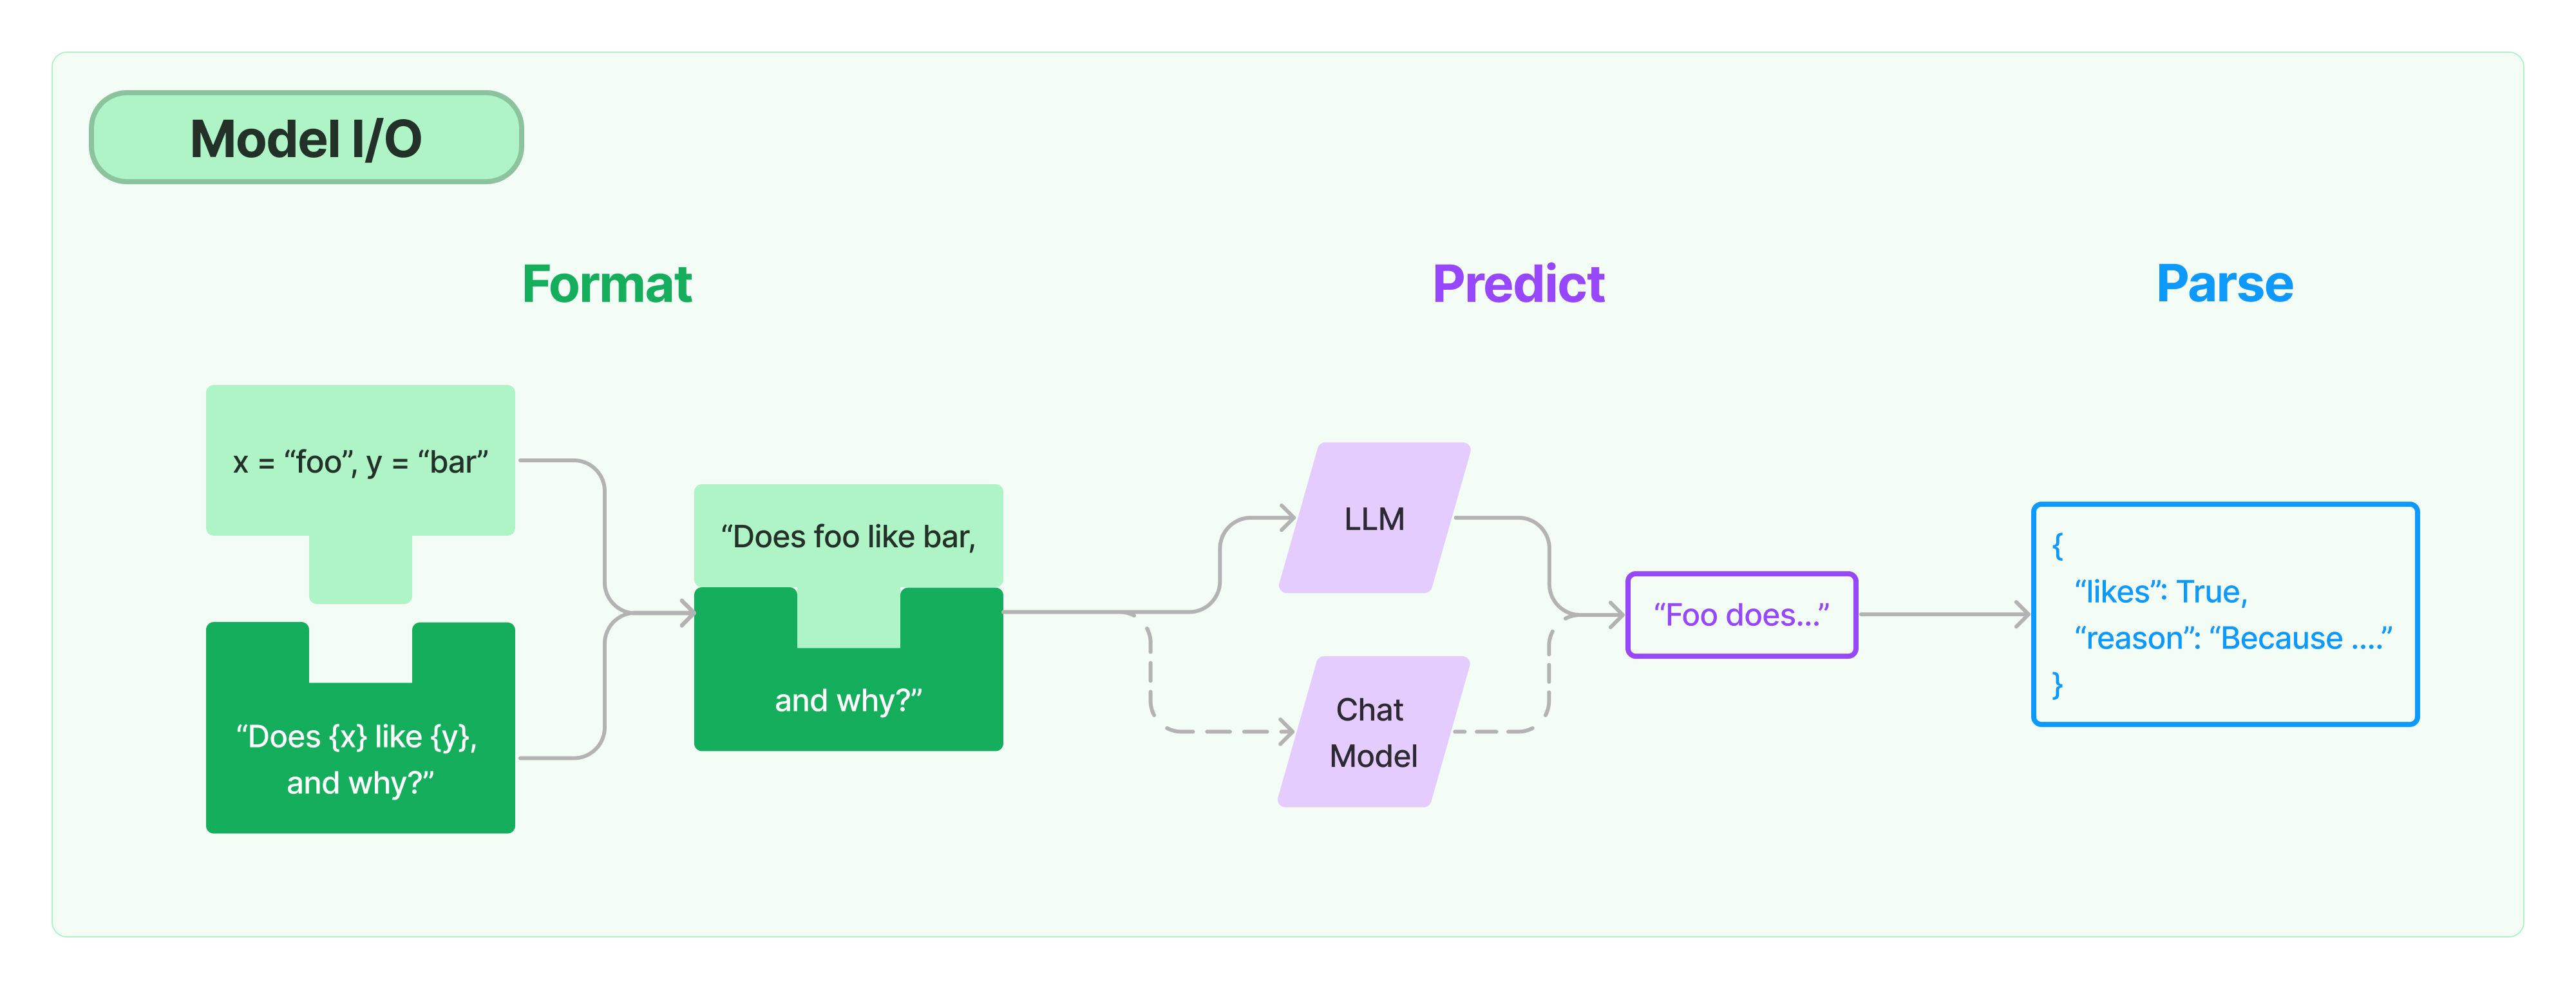

## 1.1. Prompts

### 1.1.1. Prompt templates

**What is a prompt template?**

In [ ]:
template = """You are a naming consultant for new companies. What is a good name for a company that makes {product}?"""

prompt = PromptTemplate.from_template(template)
prompt.format(product="colorful socks")

'You are a naming consultant for new companies. What is a good name for a company that makes colorful socks?'

**Create a prompt template**

In [ ]:
# Create template using input_variables variable

# An example prompt with no input variables
no_input_prompt = PromptTemplate(input_variables=[], template="Tell me a joke.")
print(no_input_prompt.format())
# -> "Tell me a joke."

# An example prompt with one input variable
one_input_prompt = PromptTemplate(input_variables=["adjective"], template="Tell me a {adjective} joke.")
print(one_input_prompt.format(adjective="funny"))
# -> "Tell me a funny joke."

# An example prompt with multiple input variables
multiple_input_prompt = PromptTemplate(
    input_variables=["adjective", "content"],
    template="Tell me a {adjective} joke about {content}."
)
print(multiple_input_prompt.format(adjective="funny", content="chickens"))
# -> "Tell me a funny joke about chickens."

Tell me a joke.
Tell me a funny joke.
Tell me a funny joke about chickens.


In [ ]:
# Create template using from_template method

template = "Tell me a {adjective} joke about {content}."

prompt_template = PromptTemplate.from_template(template)
print("input_variables:", prompt_template.input_variables)
# -> ['adjective', 'content']
print(prompt_template.format(adjective="funny", content="chickens"))
# -> Tell me a funny joke about chickens.

**Chat prompt template**

In OpenAI messages can be associated with several roles (System, AI, Human). There are specific templates for these roles in LangChain

In [ ]:
# Create a template is associated with System role
template="You are a helpful assistant that translates {input_language} to {output_language}."
system_message_prompt = SystemMessagePromptTemplate.from_template(template)

In [ ]:
# this is the same
prompt=PromptTemplate(
    template="You are a helpful assistant that translates {input_language} to {output_language}.",
    input_variables=["input_language", "output_language"],
)
system_message_prompt_2 = SystemMessagePromptTemplate(prompt=prompt)

assert system_message_prompt == system_message_prompt_2

In [ ]:
# Create a template is associated with Human role
human_template="{text}"
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

In [ ]:
# Combine created templates in one
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
chat_prompt.format_prompt(input_language='English', output_language='Russian', text='I like LangChain').to_messages()

**Custom prompt template**

We will create a custom prompt template that takes in the function name and its source code as input and formats the prompt to provide the docstring of this function.

In [ ]:
def get_source_code(function_name):
    # Get the source code of the function
    return inspect.getsource(function_name)

In [ ]:
class FunctionDocstringPromptTemplate(StringPromptTemplate, BaseModel):
    """A custom prompt template that takes in the function name its source code as input, and formats the prompt template to provide
    the docstring of the function."""

    @validator("input_variables")
    def validate_input_variables(cls, v):
        """Validate that the input variables are correct."""
        if len(v) != 2 or "function_name" not in v and "source_code" not in v:
            raise ValueError("function_name and source_code must be in input_variables.")
        return v

    def format(self, **kwargs) -> str:
        function_name = kwargs["function_name"]
        source_code = kwargs["source_code"]

        # Generate the prompt to be sent to the language model
        prompt = f"""
        Given the function name and source code, generate an English language docstring of the function.
        Function Name: {function_name}
        Source Code:
        {source_code}
        Explanation:
        """
        return prompt

    def _prompt_type(self):
        return "get-docstring"

In [ ]:
def add(a: float, b: float) -> float:
  return a + b

In [ ]:
get_docstring = FunctionDocstringPromptTemplate(input_variables=["function_name", "source_code"])

prompt = get_docstring.format(function_name=add.__name__, source_code=get_source_code(add))
print(prompt)


        Given the function name and source code, generate an English language docstring of the function.
        Function Name: add
        Source Code:
        def add(a: float, b: float) -> float:
  return a + b

        Explanation:
        


**Few-shot prompt templates**

We'll create a prompt template that uses few shot examples.

In [ ]:
examples = [
  {
    "question": "Who lived longer, Muhammad Ali or Alan Turing?",
    "answer":
"""
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali
"""
  },
  {
    "question": "When was the founder of craigslist born?",
    "answer":
"""
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952
"""
  },
  {
    "question": "Who was the maternal grandfather of George Washington?",
    "answer":
"""
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball
"""
  },
  {
    "question": "Are both the directors of Jaws and Casino Royale from the same country?",
    "answer":
"""
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate Answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate Answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate Answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate Answer: New Zealand.
So the final answer is: No
"""
  }
]

In [ ]:
# We will use FewShotPromptTemplate

In [ ]:
example_prompt = PromptTemplate(input_variables=["question", "answer"], template="Question: {question}\n{answer}")

print(example_prompt.format(**examples[0]))

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali



In [ ]:
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="Question: {input}",
    input_variables=["input"]
)

print(prompt.format(input="Who was the father of Mary Ball Washington?"))

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali


Question: When was the founder of craigslist born?

Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952


Question: Who was the maternal grandfather of George Washington?

Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball W

In [ ]:
# We will use ExampleSelector

In [ ]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    OpenAIEmbeddings(),
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # This is the number of examples to produce.
    k=1
)

# Select the most similar example to the input.
question = "Who was the father of Mary Ball Washington?"
selected_examples = example_selector.select_examples({"question": question})
print(f"Examples most similar to the input: {question}")
for example in selected_examples:
    print("\n")
    for k, v in example.items():
        print(f"{k}: {v}")

Examples most similar to the input: Who was the father of Mary Ball Washington?


question: Who was the maternal grandfather of George Washington?
answer: 
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball



In [ ]:
prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    suffix="Question: {input}",
    input_variables=["input"]
)

print(prompt.format(input="Who was the father of Mary Ball Washington?"))

Question: Who was the maternal grandfather of George Washington?

Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball


Question: Who was the father of Mary Ball Washington?


**Format template output**

In [ ]:
chat_prompt.format(input_language="English", output_language="French", text="I love LangChain.")

'System: You are a helpful assistant that translates English to French.\nHuman: I love LangChain.'

In [ ]:
chat_prompt.format_prompt(input_language="English", output_language="French", text="I love LangChain.").to_string()

'System: You are a helpful assistant that translates English to French.\nHuman: I love LangChain.'

In [ ]:
chat_prompt.format_prompt(input_language="English", output_language="French", text="I love LangChain.").to_messages()

[SystemMessage(content='You are a helpful assistant that translates English to French.', additional_kwargs={}),
 HumanMessage(content='I love LangChain.', additional_kwargs={}, example=False)]

In [ ]:
chat_prompt.format_prompt(input_language="English", output_language="French", text="I love LangChain.")

ChatPromptValue(messages=[SystemMessage(content='You are a helpful assistant that translates English to French.', additional_kwargs={}), HumanMessage(content='I love LangChain.', additional_kwargs={}, example=False)])

**Template Formats**

In [ ]:
# Use jinja2 style
jinja2_template = "Tell me a {{ adjective }} joke about {{ content }}"
prompt = PromptTemplate.from_template(jinja2_template, template_format="jinja2")

prompt.format(adjective="funny", content="chickens")

'Tell me a funny joke about chickens'

In [ ]:
# Use f-string style
fstring_template = """Tell me a {adjective} joke about {content}"""
prompt = PromptTemplate.from_template(fstring_template)

prompt.format(adjective="funny", content="chickens")

'Tell me a funny joke about chickens'

**Partial prompt templates**

In [ ]:
# Partial With Strings
prompt = PromptTemplate(template="{foo}{bar}", input_variables=["foo", "bar"])
partial_prompt = prompt.partial(foo="foo");
print(partial_prompt.format(bar="baz"))

foobaz


In [ ]:
#  Or
prompt = PromptTemplate(template="{foo}{bar}", input_variables=["bar"], partial_variables={"foo": "foo"})
print(prompt.format(bar="baz"))

foobaz


In [ ]:
# Partial With Functions

# Define some function that return string value
def _get_datetime():
    now = datetime.now()
    return now.strftime("%m/%d/%Y, %H:%M:%S")

In [ ]:
prompt = PromptTemplate(
    template="Tell me a {adjective} joke about the day {date}",
    input_variables=["adjective", "date"]
);
partial_prompt = prompt.partial(date=_get_datetime)
print(partial_prompt.format(adjective="funny"))

Tell me a funny joke about the day 07/18/2023, 08:39:18


In [ ]:
# Or
prompt = PromptTemplate(
    template="Tell me a {adjective} joke about the day {date}",
    input_variables=["adjective"],
    partial_variables={"date": _get_datetime}
);
print(prompt.format(adjective="funny"))

Tell me a funny joke about the day 07/18/2023, 08:39:20


**Composition**

In [ ]:
full_template = """{introduction}

{example}

{start}"""
full_prompt = PromptTemplate.from_template(full_template)

In [ ]:
introduction_template = """You are impersonating {person}."""
introduction_prompt = PromptTemplate.from_template(introduction_template)

In [ ]:
example_template = """Here's an example of an interaction:

Q: {example_q}
A: {example_a}"""
example_prompt = PromptTemplate.from_template(example_template)

In [ ]:
start_template = """Now, do this for real!

Q: {input}
A:"""
start_prompt = PromptTemplate.from_template(start_template)

In [ ]:
input_prompts = [
    ("introduction", introduction_prompt),
    ("example", example_prompt),
    ("start", start_prompt)
]
pipeline_prompt = PipelinePromptTemplate(final_prompt=full_prompt, pipeline_prompts=input_prompts)

In [ ]:
pipeline_prompt.input_variables

['input', 'person', 'example_a', 'example_q']

In [ ]:
print(pipeline_prompt.format(
    person="Elon Musk",
    example_q="What's your favorite car?",
    example_a="Tesla",
    input="What's your favorite social media site?"
))

You are impersonating Elon Musk.

Here's an example of an interaction: 

Q: What's your favorite car?
A: Tesla

Now, do this for real!

Q: What's your favorite social media site?
A:


**Serialization**

In [ ]:
# Loading from YAML

In [ ]:
# simple_prompt.yaml
#
# _type: prompt
# input_variables:
#     ["adjective", "content"]
# template:
#     Tell me a {adjective} joke about {content}.

prompt = load_prompt("/content/drive/MyDrive/Colab Notebooks/Data/simple_prompt.yaml")
print(prompt.format(adjective="funny", content="chickens"))

Tell me a funny joke about chickens.


In [ ]:
# Loading from JSON

In [ ]:
# simple_prompt.json
#
# {
#   "_type": "prompt",
#   "input_variables": ["adjective", "content"],
#   "template": "Tell me a {adjective} joke about {content}."
# }

prompt = load_prompt("/content/drive/MyDrive/Colab Notebooks/Data/simple_prompt.json")
print(prompt.format(adjective="funny", content="chickens"))

Tell me a funny joke about chickens.


In [ ]:
# And so on. LaneChain supports specifying everything in one file, or storing different components
#  (templates, examples, etc) in different files and referencing them.
# More details: https://python.langchain.com/docs/modules/model_io/prompts/prompt_templates/prompt_serialization

Validate template

In [ ]:
from pydantic.error_wrappers import ValidationError
template = "I am learning langchain because {reason}."

try:
  prompt_template = PromptTemplate(template=template,
                                  input_variables=["reason", "foo"]) # ValidationError due to extra variables
except ValidationError as err:
  print(err)

prompt_template = PromptTemplate(template=template,
                                 input_variables=["reason", "foo"],
                                 validate_template=False) # No error
print("Previous command was executed without any errors")

1 validation error for PromptTemplate
__root__
  Invalid prompt schema; check for mismatched or missing input parameters. {'foo'} (type=value_error)
Previous command was executed without any errors


### 1.1.2. Example selectors

If we have a large number of examples, we may need to select which ones to include in the prompt.

**Custom example selector**

In [ ]:
class CustomExampleSelector(BaseExampleSelector):

    def __init__(self, examples: List[Dict[str, str]]):
        self.examples = examples

    def add_example(self, example: Dict[str, str]) -> None:
        """Add new example to store for a key."""
        self.examples.append(example)

    def select_examples(self, input_variables: Dict[str, str]) -> List[dict]:
        """Select which examples to use based on the inputs."""
        return np.random.choice(self.examples, size=2, replace=False)


In [ ]:
examples = [
    {"foo": "1"},
    {"foo": "2"},
    {"foo": "3"}
]

# Initialize example selector.
example_selector = CustomExampleSelector(examples)

# Select examples
example_selector.select_examples({"foo": "foo"})

array([{'foo': '2'}, {'foo': '1'}], dtype=object)

In [ ]:
# Add new example to the set of examples
example_selector.add_example({"foo": "4"})
example_selector.examples

[{'foo': '1'}, {'foo': '2'}, {'foo': '3'}, {'foo': '4'}]

In [ ]:
# Select examples
example_selector.select_examples({"foo": "foo"})

array([{'foo': '1'}, {'foo': '4'}], dtype=object)

**Select by length**

This example selector selects which examples to use based on length. This is useful when you are worried about constructing a prompt that will go over the length of the context window. For longer inputs, it will select fewer examples to include, while for shorter inputs it will select more.

In [ ]:
# These are a lot of examples of a pretend task of creating antonyms.
examples = [
    {"input": "happy", "output": "sad"},
    {"input": "tall", "output": "short"},
    {"input": "energetic", "output": "lethargic"},
    {"input": "sunny", "output": "gloomy"},
    {"input": "windy", "output": "calm"},
]

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)
example_selector = LengthBasedExampleSelector(
    # These are the examples it has available to choose from.
    examples=examples,
    # This is the PromptTemplate being used to format the examples.
    example_prompt=example_prompt,
    # This is the maximum length that the formatted examples should be.
    # Length is measured by the get_text_length function below.
    max_length=25,
    # This is the function used to get the length of a string, which is used
    # to determine which examples to include. It is commented out because
    # it is provided as a default value if none is specified.
    get_text_length=lambda x: len(re.split("\n| ", x))
)
dynamic_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)

In [ ]:
# An example with small input, so it selects all examples.
print(dynamic_prompt.format(adjective="big"))

Give the antonym of every input

Input: happy
Output: sad

Input: tall
Output: short

Input: energetic
Output: lethargic

Input: sunny
Output: gloomy

Input: windy
Output: calm

Input: big
Output:


In [ ]:
# An example with long input, so it selects only one example.
long_string = "big and huge and massive and large and gigantic and tall and much much much much much bigger than everything else"
print(dynamic_prompt.format(adjective=long_string))

Give the antonym of every input

Input: happy
Output: sad

Input: big and huge and massive and large and gigantic and tall and much much much much much bigger than everything else
Output:


In [ ]:
# You can add an example to an example selector as well.
new_example = {"input": "big", "output": "small"}
dynamic_prompt.example_selector.add_example(new_example)
print(dynamic_prompt.format(adjective="enthusiastic"))

Give the antonym of every input

Input: happy
Output: sad

Input: tall
Output: short

Input: energetic
Output: lethargic

Input: sunny
Output: gloomy

Input: windy
Output: calm

Input: big
Output: small

Input: enthusiastic
Output:


**Select by maximal marginal relevance (MMR)**

The MaxMarginalRelevanceExampleSelector selects examples based on a combination of which examples are most similar to the inputs, while also optimizing for diversity. It does this by finding the examples with the embeddings that have the greatest cosine similarity with the inputs, and then iteratively adding them while penalizing them for closeness to already selected examples.

In [ ]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)

# These are a lot of examples of a pretend task of creating antonyms.
examples = [
    {"input": "happy", "output": "sad"},
    {"input": "tall", "output": "short"},
    {"input": "energetic", "output": "lethargic"},
    {"input": "sunny", "output": "gloomy"},
    {"input": "windy", "output": "calm"},
]

In [ ]:
example_selector = MaxMarginalRelevanceExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    OpenAIEmbeddings(),
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # This is the number of examples to produce.
    k=2,
)
mmr_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)

In [ ]:
# Input is a feeling, so should select the happy/sad example as the first one
print(mmr_prompt.format(adjective="worried"))

Give the antonym of every input

Input: happy
Output: sad

Input: windy
Output: calm

Input: worried
Output:


In [ ]:
# Let's compare this to what we would just get if we went solely off of similarity,
# by using SemanticSimilarityExampleSelector instead of MaxMarginalRelevanceExampleSelector.
example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    OpenAIEmbeddings(),
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # This is the number of examples to produce.
    k=2,
)
similar_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)
print(similar_prompt.format(adjective="worried"))

Give the antonym of every input

Input: happy
Output: sad

Input: sunny
Output: gloomy

Input: worried
Output:


**Select by n-gram overlap**

The NGramOverlapExampleSelector selects and orders examples based on which examples are most similar to the input, according to an ngram overlap score. The ngram overlap score is a float between 0.0 and 1.0, inclusive.

The selector allows for a threshold score to be set. Examples with an ngram overlap score less than or equal to the threshold are excluded. The threshold is set to -1.0, by default, so will not exclude any examples, only reorder them. Setting the threshold to 0.0 will exclude examples that have no ngram overlaps with the input.

In [ ]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)

# These are examples of a fictional translation task.
examples = [
    {"input": "See Spot run.", "output": "Ver correr a Spot."},
    {"input": "My dog barks.", "output": "Mi perro ladra."},
    {"input": "Spot can run.", "output": "Spot puede correr."},
]

In [ ]:
example_selector = NGramOverlapExampleSelector(
    # These are the examples it has available to choose from.
    examples=examples,
    # This is the PromptTemplate being used to format the examples.
    example_prompt=example_prompt,
    # This is the threshold, at which selector stops.
    # It is set to -1.0 by default.
    threshold=-1.0,
    # For negative threshold:
    # Selector sorts examples by ngram overlap score, and excludes none.
    # For threshold greater than 1.0:
    # Selector excludes all examples, and returns an empty list.
    # For threshold equal to 0.0:
    # Selector sorts examples by ngram overlap score,
    # and excludes those with no ngram overlap with input.
)
dynamic_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the Spanish translation of every input",
    suffix="Input: {sentence}\nOutput:",
    input_variables=["sentence"],
)

In [ ]:
# An example input with large ngram overlap with "Spot can run."
# and no overlap with "My dog barks."
print(dynamic_prompt.format(sentence="Spot can run fast."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: See Spot run.
Output: Ver correr a Spot.

Input: My dog barks.
Output: Mi perro ladra.

Input: Spot can run fast.
Output:


In [ ]:
# You can add examples to NGramOverlapExampleSelector as well.
new_example = {"input": "Spot plays fetch.", "output": "Spot juega a buscar."}

example_selector.add_example(new_example)
print(dynamic_prompt.format(sentence="Spot can run fast."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: See Spot run.
Output: Ver correr a Spot.

Input: Spot plays fetch.
Output: Spot juega a buscar.

Input: My dog barks.
Output: Mi perro ladra.

Input: Spot can run fast.
Output:


In [ ]:
# You can set a threshold at which examples are excluded.
# For example, setting threshold equal to 0.0
# excludes examples with no ngram overlaps with input.
# Since "My dog barks." has no ngram overlaps with "Spot can run fast."
# it is excluded.
example_selector.threshold = 0.0
print(dynamic_prompt.format(sentence="Spot can run fast."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: See Spot run.
Output: Ver correr a Spot.

Input: Spot plays fetch.
Output: Spot juega a buscar.

Input: Spot can run fast.
Output:


In [ ]:
# Setting small nonzero threshold
example_selector.threshold = 0.09
print(dynamic_prompt.format(sentence="Spot can play fetch."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: Spot plays fetch.
Output: Spot juega a buscar.

Input: Spot can play fetch.
Output:


In [ ]:
# Setting threshold greater than 1.0
example_selector.threshold = 1.0 + 1e-9
print(dynamic_prompt.format(sentence="Spot can play fetch."))

Give the Spanish translation of every input

Input: Spot can play fetch.
Output:


**Select by similarity**

This object selects examples based on similarity to the inputs. It does this by finding the examples with the embeddings that have the greatest cosine similarity with the inputs.

In [ ]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)

# These are a lot of examples of a pretend task of creating antonyms.
examples = [
    {"input": "happy", "output": "sad"},
    {"input": "tall", "output": "short"},
    {"input": "energetic", "output": "lethargic"},
    {"input": "sunny", "output": "gloomy"},
    {"input": "windy", "output": "calm"},
]

In [ ]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    OpenAIEmbeddings(),
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # This is the number of examples to produce.
    k=1
)
similar_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)

In [ ]:
# Input is a feeling, so should select the happy/sad example
print(similar_prompt.format(adjective="worried"))

Give the antonym of every input

Input: happy
Output: sad

Input: worried
Output:


In [ ]:
print(similar_prompt.format(adjective="big"))

Give the antonym of every input

Input: tall
Output: short

Input: big
Output:


## 1.2. Language models

### 1.2.1. LLMs

In [ ]:
llm = OpenAI()

In [ ]:
llm("Tell me a joke")

"\n\nQ: What did one wall say to the other wall?\nA: I'll meet you at the corner!"

In [ ]:
llm_result = llm.generate(["Tell me a joke", "Tell me a poem"]*2)

In [ ]:
len(llm_result.generations)

4

In [ ]:
llm_result.generations

[[Generation(text='\n\nQ: What did the fish say when it hit the wall?\nA: Dam!', generation_info={'finish_reason': 'stop', 'logprobs': None})],
 [Generation(text='\n\nRoses are red,\nViolets are blue,\nSugar is sweet,\nAnd so are you.', generation_info={'finish_reason': 'stop', 'logprobs': None})],
 [Generation(text='\n\nQ: What did the fish say when it hit the wall?\nA: Dam!', generation_info={'finish_reason': 'stop', 'logprobs': None})],
 [Generation(text='\n\nRoses are red,\nViolets are blue,\nSugar is sweet,\nAnd so are you!', generation_info={'finish_reason': 'stop', 'logprobs': None})]]

In [ ]:
llm_result.llm_output

{'token_usage': {'total_tokens': 108,
  'completion_tokens': 92,
  'prompt_tokens': 16},
 'model_name': 'text-davinci-003'}

Async API

In [ ]:
def generate_serially():
  llm = OpenAI(temperature=0.9)
  for _ in range(10):
    resp = llm.generate(["Hello, how are you?"])
    print(resp.generations[0][0].text)


async def async_generate(llm):
  resp = await llm.agenerate(["Hello, how are you?"])
  print(resp.generations[0][0].text)


async def generate_concurrently():
  llm = OpenAI(temperature=0.9)
  tasks = [async_generate(llm) for _ in range(10)]
  await asyncio.gather(*tasks)

In [ ]:
s = time.perf_counter()
await generate_concurrently()
elapsed = time.perf_counter() - s
print("\033[1m" + f"Concurrent executed in {elapsed:0.2f} seconds." + "\033[0m")

s = time.perf_counter()
generate_serially()
elapsed = time.perf_counter() - s
print("\033[1m" + f"Serial executed in {elapsed:0.2f} seconds." + "\033[0m")



I'm doing well, thank you! How about you?


I'm doing great, thank you. How about you?

I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?
 

I'm doing great, thanks! How about you?


I'm doing great, thank you. How about you?


I'm doing well, thanks for asking. And how about you?


I'm doing great, thank you for asking! How about yourself?

I am doing well, thank you. How about you?
Concurrent executed in 1.24 seconds.


I'm doing well, thanks. How about yourself?


I'm doing great, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you! How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing great, thank you. How about you?
Serial executed in 8.46 seconds.


Fake LLM

In [ ]:
tools = load_tools(["python_repl"])

In [ ]:
responses = ["Action: Python REPL\nAction Input: print(2 + 2)", "Final Answer: 4"]
llm = FakeListLLM(responses=responses)

In [ ]:
agent = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

In [ ]:
agent.run("whats 2 + 2")



> Entering new AgentExecutor chain...
Action: Python REPL
Action Input: print(2 + 2)
Observation: Python REPL is not a valid tool, try another one.
Thought:Final Answer: 4

> Finished chain.


'4'

Caching

In [ ]:
llm = OpenAI(model_name="text-davinci-002", n=2, best_of=2, cache=True)

In [ ]:
# In Memory Cache
langchain.llm_cache = InMemoryCache()

In [ ]:
%%time
# The first time, it is not yet in cache, so it should take longer
llm.predict("Tell me a joke")

CPU times: user 87.7 ms, sys: 2.88 ms, total: 90.6 ms
Wall time: 981 ms


'\n\nWhy did the chicken cross the road?\n\nTo get to the other side!'

In [ ]:
%%time
# Now we are using cache
llm.predict("Tell me a joke")

CPU times: user 364 µs, sys: 0 ns, total: 364 µs
Wall time: 371 µs


'\n\nWhy did the chicken cross the road?\n\nTo get to the other side!'

In [ ]:
# SQLite Cache
# We can do the same thing with a SQLite cache
langchain.llm_cache = SQLiteCache(database_path=".langchain.db")

In [ ]:
%%time
llm.predict("Tell me a joke") # First request

CPU times: user 21.9 ms, sys: 1.06 ms, total: 22.9 ms
Wall time: 1.13 s


"\n\nWhy couldn't the bicycle stand up by itself? Because it was...two tired!"

In [ ]:
%%time
llm.predict("Tell me a joke") # Now we are using cache

CPU times: user 3.21 ms, sys: 3 µs, total: 3.21 ms
Wall time: 4.85 ms


"\n\nWhy couldn't the bicycle stand up by itself? Because it was...two tired!"

In [ ]:
langchain.llm_cache = None

Serialization

In [ ]:
!cat "/content/drive/MyDrive/Colab Notebooks/Data/llm.json"

{
    "model_name": "text-davinci-003",
    "temperature": 0.7,
    "max_tokens": 256,
    "top_p": 1.0,
    "frequency_penalty": 0.0,
    "presence_penalty": 0.0,
    "n": 1,
    "best_of": 1,
    "request_timeout": null,
    "_type": "openai"
}

In [ ]:
llm = load_llm("/content/drive/MyDrive/Colab Notebooks/Data/llm.json")
llm.model_name

'text-davinci-003'

In [ ]:
!cat "/content/drive/MyDrive/Colab Notebooks/Data/llm.yaml"

_type: openai
best_of: 1
frequency_penalty: 0.0
max_tokens: 256
model_name: text-davinci-003
n: 1
presence_penalty: 0.0
request_timeout: null
temperature: 0.7
top_p: 1.0

In [ ]:
llm = load_llm("/content/drive/MyDrive/Colab Notebooks/Data/llm.yaml")
llm.model_name

'text-davinci-003'

Tracking token usage

In [ ]:
llm = OpenAI(model_name="text-davinci-002", n=2, best_of=2)

In [ ]:
with get_openai_callback() as cb:
    result = llm("Tell me a joke")
    print(cb)

Tokens Used: 42
	Prompt Tokens: 4
	Completion Tokens: 38
Successful Requests: 1
Total Cost (USD): $0.00084


In [ ]:
with get_openai_callback() as cb:
    result = llm("Tell me a joke")
    result2 = llm("Tell me a joke")
    print(cb.total_tokens)

75


In [ ]:
get_all_tool_names()

['python_repl',
 'requests',
 'requests_get',
 'requests_post',
 'requests_patch',
 'requests_put',
 'requests_delete',
 'terminal',
 'sleep',
 'wolfram-alpha',
 'google-search',
 'google-search-results-json',
 'searx-search-results-json',
 'bing-search',
 'metaphor-search',
 'ddg-search',
 'google-serper',
 'google-serper-results-json',
 'serpapi',
 'twilio',
 'searx-search',
 'wikipedia',
 'arxiv',
 'golden-query',
 'pupmed',
 'human',
 'awslambda',
 'sceneXplain',
 'graphql',
 'openweathermap-api',
 'dataforseo-api-search',
 'dataforseo-api-search-json',
 'news-api',
 'tmdb-api',
 'podcast-api',
 'pal-math',
 'pal-colored-objects',
 'llm-math',
 'open-meteo-api']

In [ ]:
llm = OpenAI(temperature=0)
tools = load_tools(["wikipedia", "llm-math"], llm=llm)
agent = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

In [ ]:
with get_openai_callback() as cb:
    response = agent.run(
        "Who is Olivia Wilde's boyfriend? What is his current age raised to the 0.23 power?"
    )
    print(f"Total Tokens: {cb.total_tokens}")
    print(f"Prompt Tokens: {cb.prompt_tokens}")
    print(f"Completion Tokens: {cb.completion_tokens}")
    print(f"Total Cost (USD): ${cb.total_cost}")



> Entering new AgentExecutor chain...
 I need to find out who Olivia Wilde's boyfriend is and then calculate his age raised to the 0.23 power.
Action: Wikipedia
Action Input: Olivia Wilde
Observation: Page: Olivia Wilde
Summary: Olivia Jane Cockburn ( KOH-bərn; born March 10, 1984), known professionally as Olivia Wilde, is an American actress and filmmaker. She played Remy "Thirteen" Hadley on the medical-drama television series House (2007–2012), and has appeared in the films Tron: Legacy (2010), Cowboys & Aliens (2011),  The Incredible Burt Wonderstone (2013), and The Lazarus Effect (2015). Wilde made her Broadway debut in 2017, playing Julia in 1984. In 2019, she directed her first film, the teen comedy Booksmart (2019), for which she won the Independent Spirit Award for Best First Feature. Wilde's second feature as director, Don't Worry Darling, was released in 2022.

Page: Olivia Wilde filmography
Summary: Olivia Wilde is an American actress and filmmaker. She is known for her r

### 1.2.2.Chat models

In [ ]:
chat = ChatOpenAI()

In [ ]:
chat([HumanMessage(content="Translate this sentence from English to French: I love programming.")])

AIMessage(content="J'adore la programmation.", additional_kwargs={}, example=False)

In [ ]:
messages = [
    SystemMessage(content="You are a helpful assistant that translates English to French."),
    HumanMessage(content="I love programming.")
]
chat(messages)

AIMessage(content="J'adore la programmation.", additional_kwargs={}, example=False)

In [ ]:
batch_messages = [
    [
        SystemMessage(content="You are a helpful assistant that translates English to French."),
        HumanMessage(content="I love programming.")
    ],
    [
        SystemMessage(content="You are a helpful assistant that translates English to French."),
        HumanMessage(content="I love artificial intelligence.")
    ],
]
result = chat.generate(batch_messages)
result

LLMResult(generations=[[ChatGeneration(text="J'adore programmer.", generation_info={'finish_reason': 'stop'}, message=AIMessage(content="J'adore programmer.", additional_kwargs={}, example=False))], [ChatGeneration(text="J'adore l'intelligence artificielle.", generation_info={'finish_reason': 'stop'}, message=AIMessage(content="J'adore l'intelligence artificielle.", additional_kwargs={}, example=False))]], llm_output={'token_usage': {'prompt_tokens': 53, 'completion_tokens': 18, 'total_tokens': 71}, 'model_name': 'gpt-3.5-turbo'}, run=[RunInfo(run_id=UUID('c27b8d71-7c25-4114-bcae-306b5cd90478')), RunInfo(run_id=UUID('8ed8b4e1-4775-4361-a19c-0d4a1f6015bf'))])

In [ ]:
result.llm_output

{'token_usage': {'prompt_tokens': 53,
  'completion_tokens': 18,
  'total_tokens': 71},
 'model_name': 'gpt-3.5-turbo'}

## 1.3. Output parsers

In [ ]:
model_name = 'text-davinci-003'
temperature = 0.0
model = OpenAI(model_name=model_name, temperature=temperature)

In [ ]:
# Define your desired data structure.
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")

    # You can add custom validation logic easily with Pydantic.
    @validator('setup')
    def question_ends_with_question_mark(cls, field):
        if field[-1] != '?':
            raise ValueError("Badly formed question!")
        return field

In [ ]:
# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Joke)

In [ ]:
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

In [ ]:
prompt

PromptTemplate(input_variables=['query'], output_parser=None, partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}\n```'}, template='Answer the user query.\n{format_instructions}\n{query}\n', template_format='f-string', validate_template=True)

In [ ]:
# And a query intended to prompt a language model to populate the data structure.
joke_query = "Tell me a joke."
_input = prompt.format_prompt(query=joke_query)
print(_input.text)

Answer the user query.
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}
```
Tell me a joke.



In [ ]:
output = model(_input.to_string())

In [ ]:
print(output)


{"setup": "Why did the chicken cross the road?", "punchline": "To get to the other side!"}


In [ ]:
parser.parse(output)

Joke(setup='Why did the chicken cross the road?', punchline='To get to the other side!')

List parser

In [ ]:
model = OpenAI(temperature=0)

In [ ]:
output_parser = CommaSeparatedListOutputParser()

In [ ]:
format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    template="List five {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions}
)

In [ ]:
_input = prompt.format(subject="ice cream flavors")
print(_input)

List five ice cream flavors.
Your response should be a list of comma separated values, eg: `foo, bar, baz`


In [ ]:
output = model(_input)
output_parser.parse(output)

['Vanilla',
 'Chocolate',
 'Strawberry',
 'Mint Chocolate Chip',
 'Cookies and Cream']

Datetime parser

In [ ]:
chain = LLMChain(prompt=prompt, llm=OpenAI())

In [ ]:
output_parser = DatetimeOutputParser()
template = """Answer the users question:

{question}

{format_instructions}"""
prompt = PromptTemplate.from_template(
    template,
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
)

In [ ]:
prompt

PromptTemplate(input_variables=['question'], output_parser=None, partial_variables={'format_instructions': 'Write a datetime string that matches the \n            following pattern: "%Y-%m-%dT%H:%M:%S.%fZ". Examples: 1720-02-18T01:47:20.810715Z, 1233-03-06T08:16:44.555862Z, 387-08-27T23:12:41.346060Z'}, template='Answer the users question:\n\n{question}\n\n{format_instructions}', template_format='f-string', validate_template=True)

In [ ]:
chain = LLMChain(prompt=prompt, llm=OpenAI())

In [ ]:
output = chain.run("around when was bitcoin founded?")

In [ ]:
output

'\n\n2009-01-03T18:15:05.000000Z'

In [ ]:
output_parser.parse(output)

datetime.datetime(2009, 1, 3, 18, 15, 5)

Enum parser

In [ ]:
class Colors(Enum):
    RED = "red"
    GREEN = "green"
    BLUE = "blue"

In [ ]:
parser = EnumOutputParser(enum=Colors)
parser.parse("red")

<Colors.RED: 'red'>

In [ ]:
parser.get_format_instructions()

'Select one of the following options: red, green, blue'

Auto-fixing parser

In [ ]:
class Actor(BaseModel):
    name: str = Field(description="name of an actor")
    film_names: List[str] = Field(description="list of names of films they starred in")

actor_query = "Generate the filmography for a random actor."

parser = PydanticOutputParser(pydantic_object=Actor)

In [ ]:
misformatted = "{'name': 'Tom Hanks', 'film_names': ['Forrest Gump']}"

In [ ]:
parser.parse(misformatted)

OutputParserException: ignored

In [ ]:
new_parser = OutputFixingParser.from_llm(parser=parser, llm=ChatOpenAI())

In [ ]:
new_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"name": {"title": "Name", "description": "name of an actor", "type": "string"}, "film_names": {"title": "Film Names", "description": "list of names of films they starred in", "type": "array", "items": {"type": "string"}}}, "required": ["name", "film_names"]}\n```'

In [ ]:
new_parser.parse(misformatted)

Actor(name='Tom Hanks', film_names=['Forrest Gump'])

Pydantic (JSON) parser

In [ ]:
model_name = "text-davinci-003"
temperature = 0.9
model = OpenAI(model_name=model_name, temperature=temperature)

In [ ]:
# Here's another example, but with a compound typed field.
class Actor(BaseModel):
    name: str = Field(description="name of an actor")
    film_names: List[str] = Field(description="list of names of films they starred in")


actor_query = "Generate the filmography for a random actor."

parser = PydanticOutputParser(pydantic_object=Actor)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

_input = prompt.format_prompt(query=actor_query)

output = model(_input.to_string())

parser.parse(output)

Actor(name='Jack Nicholson', film_names=["One Flew Over the Cuckoo's Nest", 'The Shining', 'Easy Rider', 'Batman', 'Five Easy Pieces'])

Retry parser

While in some cases it is possible to fix any parsing mistakes by only looking at the output, in other cases it can't. An example of this is when the output is not just in the incorrect format, but is partially complete. Consider the below example.

In [ ]:
template = """Based on the user question, provide an Action and Action Input for what step should be taken.
{format_instructions}
Question: {query}
Response:"""


class Action(BaseModel):
    action: str = Field(description="action to take")
    action_input: str = Field(description="input to the action")


parser = PydanticOutputParser(pydantic_object=Action)

In [ ]:
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

In [ ]:
prompt

PromptTemplate(input_variables=['query'], output_parser=None, partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"action": {"title": "Action", "description": "action to take", "type": "string"}, "action_input": {"title": "Action Input", "description": "input to the action", "type": "string"}}, "required": ["action", "action_input"]}\n```'}, template='Answer the user query.\n{format_instructions}\n{query}\n', template_format='f-string', validate_template=True)

In [ ]:
prompt_value = prompt.format_prompt(query="who is leo di caprios gf?")
print(prompt_value.text)

Answer the user query.
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"action": {"title": "Action", "description": "action to take", "type": "string"}, "action_input": {"title": "Action Input", "description": "input to the action", "type": "string"}}, "required": ["action", "action_input"]}
```
who is leo di caprios gf?



In [ ]:
bad_response = '{"action": "search"}'

In [ ]:
parser.parse(bad_response)

OutputParserException: ignored

In [ ]:
fix_parser = OutputFixingParser.from_llm(parser=parser, llm=ChatOpenAI())

In [ ]:
fix_parser.parse(bad_response)

Action(action='search', action_input='input')

In [ ]:
retry_parser = RetryWithErrorOutputParser.from_llm(
    parser=parser, llm=OpenAI(temperature=0)
)

In [ ]:
retry_parser.parse_with_prompt(bad_response, prompt_value)

Action(action='search', action_input='who is leo di caprios gf?')

# 2. Data connection


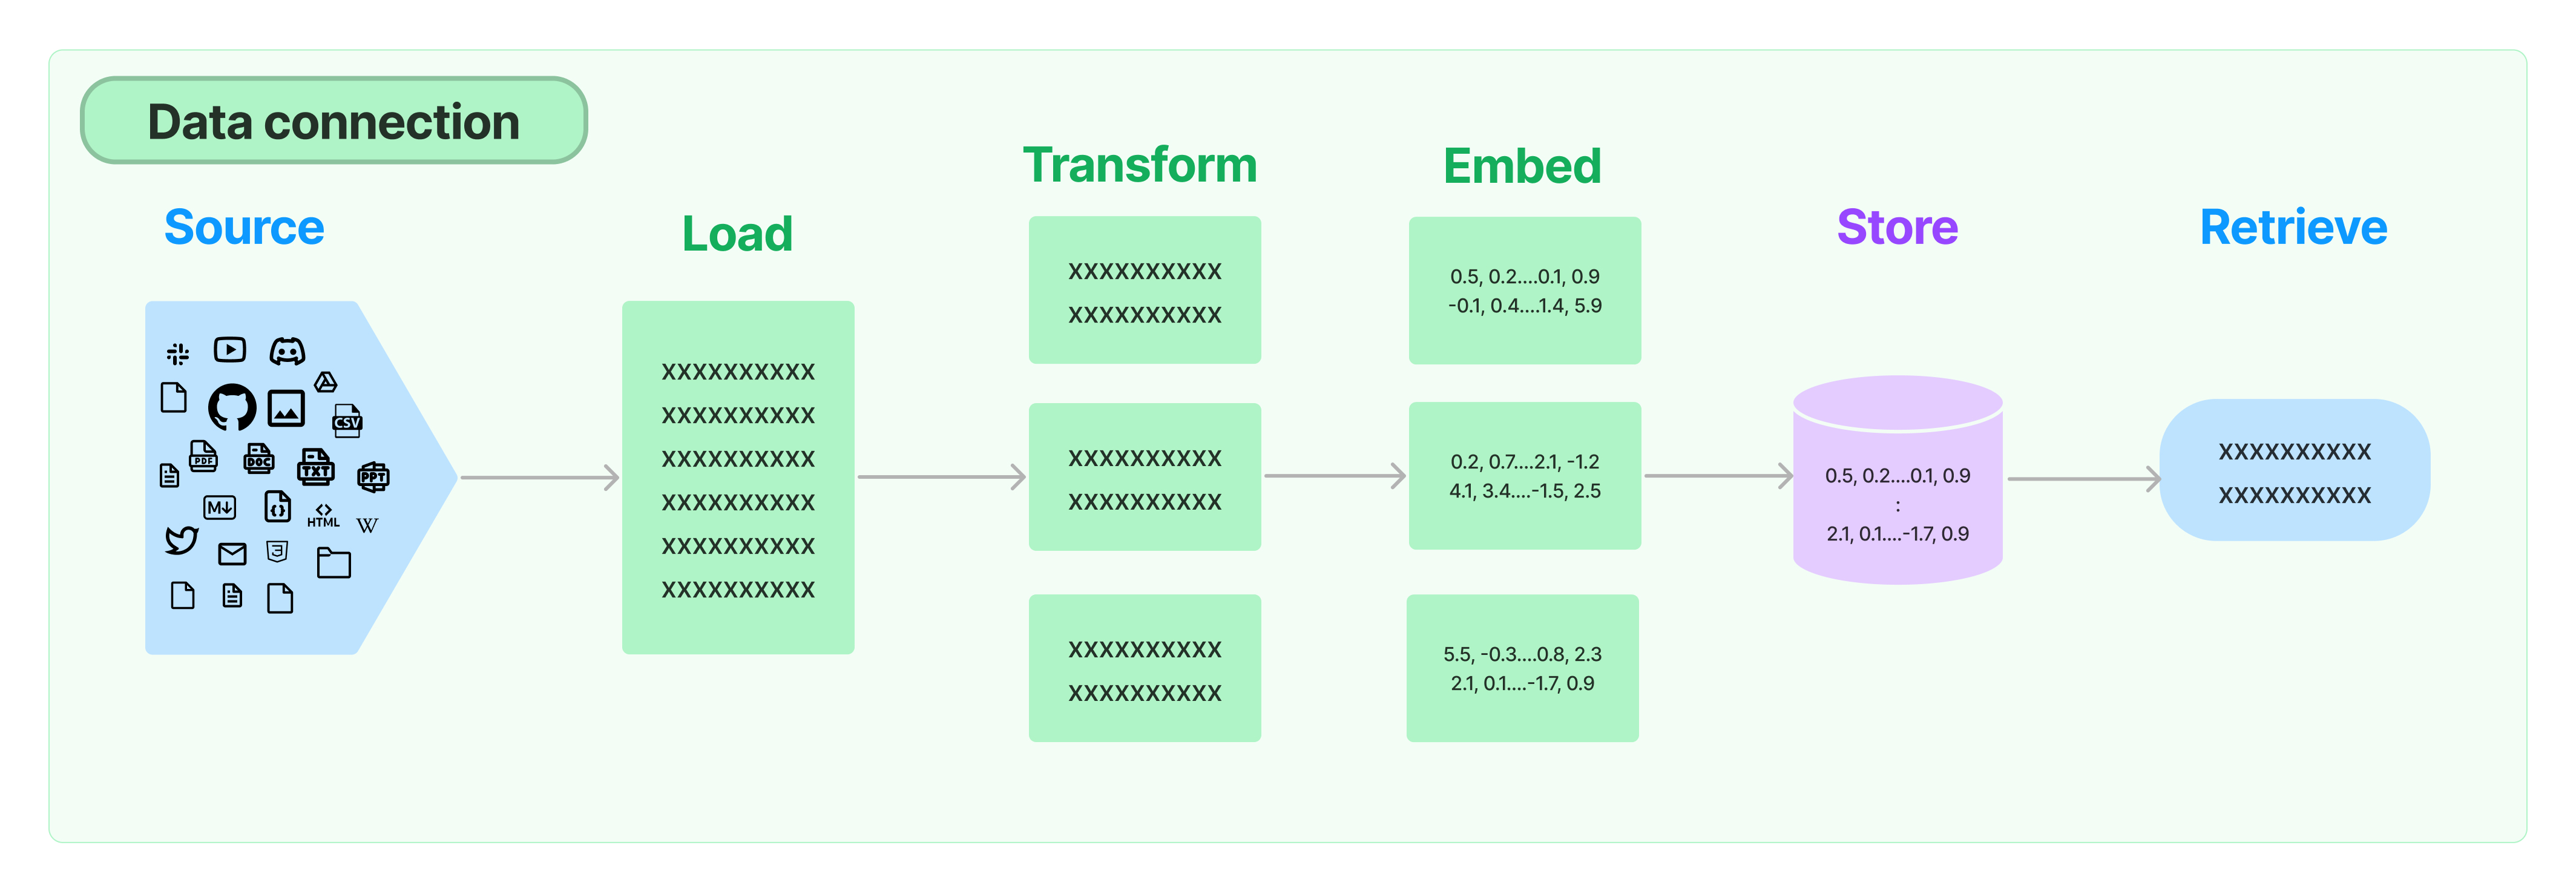

* Document loaders: Load documents from many different sources

* Document transformers: Split documents, convert documents into Q&A format, drop redundant documents, and more

* Text embedding models: Take unstructured text and turn it into a list of floating point numbers

* Vector stores: Store and search over embedded data

* Retrievers: Query your data

## 2.1. Document loaders

In [ ]:
loader = TextLoader("/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt")
loader.load()

In [ ]:
loader = CSVLoader(file_path='/content/drive/MyDrive/Colab Notebooks/Data/OutdoorClothingCatalog_1000_langchain_practice.csv')
data = loader.load()
print(data)

[Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': '/content/drive/MyDrive/Colab Notebooks/Data/OutdoorClothingCatalog_1000_langchain_practice.csv', 'row': 0}), Document(page_content=': 1\nname: Recycled Waterhog Dog Mat, 

In [ ]:
loader = UnstructuredHTMLLoader("/content/drive/MyDrive/Colab Notebooks/Data/Langchain.html")
data = loader.load()
print(data)

[Document(page_content='\n\nModules\n\nData connection\n\nDocument loaders\n\nHow-to\n\nHTML\n\nHTML\n\nThe HyperText Markup Language or HTML is the standard markup language for documents designed to be displayed in a web browser.\n\nThis covers how to load HTML documents into a document format that we can use downstream.\n\nfrom\n\nlangchain\n\ndocument_loaders\n\nimport\n\nUnstructuredHTMLLoader\n\nloader\n\nUnstructuredHTMLLoader\n\n"example_data/fake-content.html"\n\ndata\n\nloader\n\nload\n\ndata\n\n[Document(page_content=\'My First Heading\\n\\nMy first paragraph.\', lookup_str=\'\', metadata={\'source\': \'example_data/fake-content.html\'}, lookup_index=0)]\n\nLoading HTML with BeautifulSoup4\u200b\n\nWe can also use BeautifulSoup4 to load HTML documents using the BSHTMLLoader.  This will extract the text from the HTML into page_content, and the page title as title into metadata.\n\nfrom\n\nlangchain\n\ndocument_loaders\n\nimport\n\nBSHTMLLoader\n\nloader\n\nBSHTMLLoader\n\n"exa

In [ ]:
loader = BSHTMLLoader("/content/drive/MyDrive/Colab Notebooks/Data/Langchain.html")
data = loader.load()
print(data)

[Document(page_content='\n\n\n\nHTML | 🦜️🔗 Langchain\n\n\n\n\n\nSkip to main content🦜️🔗 LangChainDocsUse casesIntegrationsAPILangSmithJS/TS DocsCTRLKGet startedIntroductionInstallationQuickstartModulesModel I/\u200bOData connectionDocument loadersHow-toCSVFile DirectoryHTMLJSONMarkdownPDFIntegrationsDocument transformersText embedding modelsVector storesRetrieversChainsMemoryAgentsCallbacksEvaluationModulesGuidesEcosystemAdditional resourcesModulesData connectionDocument loadersHow-toHTMLHTMLThe HyperText Markup Language or HTML is the standard markup language for documents designed to be displayed in a web browser.This covers how to load HTML documents into a document format that we can use downstream.from langchain.document_loaders import UnstructuredHTMLLoaderloader = UnstructuredHTMLLoader("example_data/fake-content.html")data = loader.load()data    [Document(page_content=\'My First Heading\\n\\nMy first paragraph.\', lookup_str=\'\', metadata={\'source\': \'example_data/fake-conte

In [ ]:
data[0].metadata

{'source': '/content/drive/MyDrive/Colab Notebooks/Data/Langchain.html',
 'title': 'HTML | 🦜️🔗 Langchain'}

In [ ]:
data ={
    'age' : ['youth', 'youth', 'middle_age', 'senior', 'senior', 'senior','middle_age', 'youth', 'youth', 'senior', 'youth', 'middle_age','middle_age', 'senior'],
    'income' : ['high', 'high', 'high', 'medium', 'low', 'low', 'low', 'medium','low', 'medium', 'medium', 'medium', 'high', 'medium'],
    'student' : ['no','no','no','no','yes','yes','yes','no','yes','yes','yes','no','yes','no'],
    'credit_rate' : ['fair', 'excellent', 'fair', 'fair', 'fair', 'excellent', 'excellent', 'fair', 'fair', 'fair','excellent', 'excellent', 'fair', 'excellent'],
    'default' : ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes','yes', 'yes', 'yes', 'no']
}
df = pd.DataFrame (data, columns=data.keys())
df.reset_index(inplace=True)
df

index         age  income student credit_rate default
0       0       youth    high      no        fair      no
1       1       youth    high      no   excellent      no
2       2  middle_age    high      no        fair     yes
3       3      senior  medium      no        fair     yes
4       4      senior     low     yes        fair     yes
5       5      senior     low     yes   excellent      no
6       6  middle_age     low     yes   excellent     yes
7       7       youth  medium      no        fair      no
8       8       youth     low     yes        fair     yes
9       9      senior  medium     yes        fair     yes
10     10       youth  medium     yes   excellent     yes
11     11  middle_age  medium      no   excellent     yes
12     12  middle_age    high     yes        fair     yes
13     13      senior  medium      no   excellent      no

In [ ]:
loader = DataFrameLoader(df, page_content_column="index")
loader.load()

[Document(page_content='0', metadata={'age': 'youth', 'income': 'high', 'student': 'no', 'credit_rate': 'fair', 'default': 'no'}),
 Document(page_content='1', metadata={'age': 'youth', 'income': 'high', 'student': 'no', 'credit_rate': 'excellent', 'default': 'no'}),
 Document(page_content='2', metadata={'age': 'middle_age', 'income': 'high', 'student': 'no', 'credit_rate': 'fair', 'default': 'yes'}),
 Document(page_content='3', metadata={'age': 'senior', 'income': 'medium', 'student': 'no', 'credit_rate': 'fair', 'default': 'yes'}),
 Document(page_content='4', metadata={'age': 'senior', 'income': 'low', 'student': 'yes', 'credit_rate': 'fair', 'default': 'yes'}),
 Document(page_content='5', metadata={'age': 'senior', 'income': 'low', 'student': 'yes', 'credit_rate': 'excellent', 'default': 'no'}),
 Document(page_content='6', metadata={'age': 'middle_age', 'income': 'low', 'student': 'yes', 'credit_rate': 'excellent', 'default': 'yes'}),
 Document(page_content='7', metadata={'age': 'you

## 2.2. Document transformers

### 2.2.1 Text splitters

Split by character

In [ ]:
# This is a long document we can split up.
with open('/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt') as f:
    book = f.read()

In [ ]:
text_splitter = CharacterTextSplitter(
  separator = "\n\n",
  chunk_size = 1000,
  chunk_overlap  = 200,
  length_function = len,
)

In [ ]:
texts = text_splitter.create_documents([book])
print(texts[0])

page_content="Isaac Asimov\n\n\nI, Robot\n\nIntroduction\n\nI LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.\n\nSusan Calvin had been born in the year 1982, they said, which made her seventy-five now. Everyone knew that. Appropriately enough, U. S. Robot and Mechanical Men, Inc. was seventy-five also, since it had been in the year of Dr. Calvin's birth that Lawrence Robertson had first taken out incorporation papers for what eventually became the strangest industrial giant in man's history. Well, everyone knew that, too.\n\nAt the age of twenty, Susan Calvin had been part of the particular Psycho-Math seminar at which Dr. Alfred Lanning of U. S. Robots had demonstrated the first mobile robot to be equipped with a voice. It was a large, clumsy unbeautiful robot, smelling of machine-oil and destined for the projected mines on Mercury. But it could speak and make sense." metadata={}

In [ ]:
text_splitter.split_text(book)[0]

"Isaac Asimov\n\n\nI, Robot\n\nIntroduction\n\nI LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.\n\nSusan Calvin had been born in the year 1982, they said, which made her seventy-five now. Everyone knew that. Appropriately enough, U. S. Robot and Mechanical Men, Inc. was seventy-five also, since it had been in the year of Dr. Calvin's birth that Lawrence Robertson had first taken out incorporation papers for what eventually became the strangest industrial giant in man's history. Well, everyone knew that, too.\n\nAt the age of twenty, Susan Calvin had been part of the particular Psycho-Math seminar at which Dr. Alfred Lanning of U. S. Robots had demonstrated the first mobile robot to be equipped with a voice. It was a large, clumsy unbeautiful robot, smelling of machine-oil and destined for the projected mines on Mercury. But it could speak and make sense."

Split code

In [ ]:
# Full list of support languages
[e.value for e in Language]

['cpp',
 'go',
 'java',
 'js',
 'php',
 'proto',
 'python',
 'rst',
 'ruby',
 'rust',
 'scala',
 'swift',
 'markdown',
 'latex',
 'html',
 'sol']

In [ ]:
# You can also see the separators used for a given language
RecursiveCharacterTextSplitter.get_separators_for_language(Language.PYTHON)

['\nclass ', '\ndef ', '\n\tdef ', '\n\n', '\n', ' ', '']

In [ ]:
PYTHON_CODE = """
def hello_world():
    print("Hello, World!")

# Call the function
hello_world()
"""
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=50, chunk_overlap=0
)
python_docs = python_splitter.create_documents([PYTHON_CODE])
python_docs

[Document(page_content='def hello_world():\n    print("Hello, World!")', metadata={}),
 Document(page_content='# Call the function\nhello_world()', metadata={})]

MarkdownHeaderTextSplitter

For example, a markdown file is organized by headers. Creating chunks within specific header groups is an intuitive idea.

In [ ]:
markdown_document = "# Foo\n\n    ## Bar\n\nHi this is Jim\n\nHi this is Joe\n\n ### Boo \n\n Hi this is Lance \n\n ## Baz\n\n Hi this is Molly"


In [ ]:
print(markdown_document)

# Foo

    ## Bar

Hi this is Jim

Hi this is Joe

 ### Boo 

 Hi this is Lance 

 ## Baz

 Hi this is Molly


In [ ]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_document)
md_header_splits

[Document(page_content='Hi this is Jim  \nHi this is Joe', metadata={'Header 1': 'Foo', 'Header 2': 'Bar'}),
 Document(page_content='Hi this is Lance', metadata={'Header 1': 'Foo', 'Header 2': 'Bar', 'Header 3': 'Boo'}),
 Document(page_content='Hi this is Molly', metadata={'Header 1': 'Foo', 'Header 2': 'Baz'})]

In [ ]:
# Within each markdown group we can then apply any text splitter we want.

In [ ]:
markdown_document = "# Intro \n\n    ## History \n\n Markdown[9] is a lightweight markup language for creating formatted text using a plain-text editor. John Gruber created Markdown in 2004 as a markup language that is appealing to human readers in its source code form.[9] \n\n Markdown is widely used in blogging, instant messaging, online forums, collaborative software, documentation pages, and readme files. \n\n ## Rise and divergence \n\n As Markdown popularity grew rapidly, many Markdown implementations appeared, driven mostly by the need for \n\n additional features such as tables, footnotes, definition lists,[note 1] and Markdown inside HTML blocks. \n\n #### Standardization \n\n From 2012, a group of people, including Jeff Atwood and John MacFarlane, launched what Atwood characterised as a standardisation effort. \n\n ## Implementations \n\n Implementations of Markdown are available for over a dozen programming languages."

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]

# MD splits
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_document)

chunk_size = 250
chunk_overlap = 30
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

# Split
splits = text_splitter.split_documents(md_header_splits)

In [ ]:
print(markdown_document)

# Intro 

    ## History 

 Markdown[9] is a lightweight markup language for creating formatted text using a plain-text editor. John Gruber created Markdown in 2004 as a markup language that is appealing to human readers in its source code form.[9] 

 Markdown is widely used in blogging, instant messaging, online forums, collaborative software, documentation pages, and readme files. 

 ## Rise and divergence 

 As Markdown popularity grew rapidly, many Markdown implementations appeared, driven mostly by the need for 

 additional features such as tables, footnotes, definition lists,[note 1] and Markdown inside HTML blocks. 

 #### Standardization 

 From 2012, a group of people, including Jeff Atwood and John MacFarlane, launched what Atwood characterised as a standardisation effort. 

 ## Implementations 

 Implementations of Markdown are available for over a dozen programming languages.


In [ ]:
splits

[Document(page_content='Markdown[9] is a lightweight markup language for creating formatted text using a plain-text editor. John Gruber created Markdown in 2004 as a markup language that is appealing to human readers in its source code form.[9]', metadata={'Header 1': 'Intro', 'Header 2': 'History'}),
 Document(page_content='Markdown is widely used in blogging, instant messaging, online forums, collaborative software, documentation pages, and readme files.', metadata={'Header 1': 'Intro', 'Header 2': 'History'}),
 Document(page_content='As Markdown popularity grew rapidly, many Markdown implementations appeared, driven mostly by the need for  \nadditional features such as tables, footnotes, definition lists,[note 1] and Markdown inside HTML blocks.  \n#### Standardization', metadata={'Header 1': 'Intro', 'Header 2': 'Rise and divergence'}),
 Document(page_content='#### Standardization  \nFrom 2012, a group of people, including Jeff Atwood and John MacFarlane, launched what Atwood chara

Recursively split by character

This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [ ]:
# This is a long document we can split up.
with open('/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt') as f:
    book = f.read()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 100,
    chunk_overlap  = 20,
    length_function = len,
)

In [ ]:
texts = text_splitter.create_documents([book])
print(texts[0])
print(texts[1])

page_content='Isaac Asimov\n\n\nI, Robot\n\n\n\nIntroduction' metadata={}
page_content="I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well" metadata={}


In [ ]:
text_splitter.split_text(book)[:2]

['Isaac Asimov\n\n\nI, Robot\n\n\n\nIntroduction',
 "I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well"]

Split by tokens

In [ ]:
# tiktoken by OpenAI

In [ ]:
# This is a long document we can split up.
with open('/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt') as f:
    book = f.read()

In [ ]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
texts = text_splitter.split_text(book)

In [ ]:
print(texts[0])

Isaac Asimov


I, Robot

Introduction

I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.

Susan Calvin had been born in the year 1982, they said, which made her seventy-five now. Everyone knew that. Appropriately enough, U. S. Robot and Mechanical Men, Inc. was seventy-five also, since it had been in the year of Dr. Calvin's birth that Lawrence Robertson had first taken out incorporation papers for what eventually became the strangest industrial giant in man's history. Well, everyone knew that, too.

At the age of twenty, Susan Calvin had been part of the particular Psycho-Math seminar at which Dr. Alfred Lanning of U. S. Robots had demonstrated the first mobile robot to be equipped with a voice. It was a large, clumsy unbeautiful robot, smelling of machine-oil and destined for the projected mines on Mercury. But it could speak and make sense.


In [ ]:
text_splitter = TokenTextSplitter(chunk_size=10, chunk_overlap=0)

texts = text_splitter.split_text(book)
print(texts[0])

Isaac Asimov


I, Robot




In [ ]:
text_in_russian = "Я иду гулять"
text_splitter = TokenTextSplitter(chunk_size=5, chunk_overlap=0)

texts = text_splitter.split_text(text_in_russian)
print(texts[0])

Я ид


spaCy

In [ ]:
text_splitter = SpacyTextSplitter(chunk_size=500)
texts = text_splitter.split_text(book)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
print(texts[0])

Isaac Asimov


I, Robot



Introduction

I LOOKED AT MY NOTES

AND I DIDN'T LIKE THEM.

I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.



Susan Calvin had been born in the year 1982, they said, which made her seventy-five now.

Everyone knew that.


In [ ]:
print(texts[1])

Susan Calvin had been born in the year 1982, they said, which made her seventy-five now.

Everyone knew that.

Appropriately enough, U. S. Robot and Mechanical Men, Inc. was seventy-five also, since it had been in the year of Dr. Calvin's birth that Lawrence Robertson had first taken out incorporation papers for what eventually became the strangest industrial giant in man's history.

Well, everyone knew that, too.


NLTK

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
text_splitter = NLTKTextSplitter(chunk_size=500)
texts = text_splitter.split_text(book)

In [ ]:
print(texts[0])

Isaac Asimov


I, Robot



Introduction

I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM.

I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.

Susan Calvin had been born in the year 1982, they said, which made her seventy-five now.

Everyone knew that.


Hugging Face tokenizer

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [ ]:
text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=500, chunk_overlap=0
)
texts = text_splitter.split_text(book)

In [ ]:
print(texts[0])

Isaac Asimov


I, Robot

Introduction

I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.

Susan Calvin had been born in the year 1982, they said, which made her seventy-five now. Everyone knew that. Appropriately enough, U. S. Robot and Mechanical Men, Inc. was seventy-five also, since it had been in the year of Dr. Calvin's birth that Lawrence Robertson had first taken out incorporation papers for what eventually became the strangest industrial giant in man's history. Well, everyone knew that, too.

At the age of twenty, Susan Calvin had been part of the particular Psycho-Math seminar at which Dr. Alfred Lanning of U. S. Robots had demonstrated the first mobile robot to be equipped with a voice. It was a large, clumsy unbeautiful robot, smelling of machine-oil and destined for the projected mines on Mercury. But it could speak and make sense.

Susan said nothing at that seminar; 

### 2.2.2. Post retrieval

Lost in the middle: The problem with long contexts

[Lost in the Middle: How Language Models Use Long Contexts
](https://arxiv.org/abs/2307.03172)

In [ ]:
# Get embeddings.
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

texts = [
    "Basquetball is a great sport.",
    "Fly me to the moon is one of my favourite songs.",
    "The Celtics are my favourite team.",
    "This is a document about the Boston Celtics",
    "I simply love going to the movies",
    "The Boston Celtics won the game by 20 points",
    "This is just a random text.",
    "Elden Ring is one of the best games in the last 15 years.",
    "L. Kornet is one of the best Celtics players.",
    "Larry Bird was an iconic NBA player.",
]

# Create a retriever
retriever = Chroma.from_texts(texts, embedding=embeddings).as_retriever(
    search_kwargs={"k": 10}
)
query = "What can you tell me about the Celtics?"

# Get relevant documents ordered by relevance score
docs = retriever.get_relevant_documents(query)
docs

[Document(page_content='This is a document about the Boston Celtics', metadata={}),
 Document(page_content='The Celtics are my favourite team.', metadata={}),
 Document(page_content='L. Kornet is one of the best Celtics players.', metadata={}),
 Document(page_content='The Boston Celtics won the game by 20 points', metadata={}),
 Document(page_content='Larry Bird was an iconic NBA player.', metadata={}),
 Document(page_content='Elden Ring is one of the best games in the last 15 years.', metadata={}),
 Document(page_content='Basquetball is a great sport.', metadata={}),
 Document(page_content='I simply love going to the movies', metadata={}),
 Document(page_content='Fly me to the moon is one of my favourite songs.', metadata={}),
 Document(page_content='This is just a random text.', metadata={})]

In [ ]:
# Reorder the documents:
# Less relevant document will be at the middle of the list and more
# relevant elements at begining / end.
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)

# Confirm that the 4 relevant documents are at begining and end.
reordered_docs

[Document(page_content='The Celtics are my favourite team.', metadata={}),
 Document(page_content='The Boston Celtics won the game by 20 points', metadata={}),
 Document(page_content='Elden Ring is one of the best games in the last 15 years.', metadata={}),
 Document(page_content='I simply love going to the movies', metadata={}),
 Document(page_content='This is just a random text.', metadata={}),
 Document(page_content='Fly me to the moon is one of my favourite songs.', metadata={}),
 Document(page_content='Basquetball is a great sport.', metadata={}),
 Document(page_content='Larry Bird was an iconic NBA player.', metadata={}),
 Document(page_content='L. Kornet is one of the best Celtics players.', metadata={}),
 Document(page_content='This is a document about the Boston Celtics', metadata={})]

In [ ]:
# We prepare and run a custom Stuff chain with reordered docs as context.

# Override prompts
document_prompt = PromptTemplate(
    input_variables=["page_content"], template="{page_content}"
)
document_variable_name = "context"
llm = OpenAI()
stuff_prompt_override = """Given this text extracts:
-----
{context}
-----
Please answer the following question:
{query}"""
prompt = PromptTemplate(
    template=stuff_prompt_override, input_variables=["context", "query"]
)

# Instantiate the chain
llm_chain = LLMChain(llm=llm, prompt=prompt)
chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_prompt=document_prompt,
    document_variable_name=document_variable_name,
)
chain.run(input_documents=reordered_docs, query=query)

'\n\nThe Celtics are a professional basketball team based in Boston, Massachusetts. They have won 17 NBA Championships, the most in the league. They have had many iconic players, such as Larry Bird, and currently have players like L. Kornet who are considered to be some of the best in the league. They have recently won a game by 20 points. They are a popular team and have many fans.'

## 2.3. Text embedding models

The base Embeddings class in LangChain exposes two methods: one for embedding documents and one for embedding a query. The former takes as input multiple texts, while the latter takes a single text. The reason for having these as two separate methods is that some embedding providers have different embedding methods for documents (to be searched over) vs queries (the search query itself).

In [ ]:
embeddings_model = OpenAIEmbeddings()

In [ ]:
embeddings = embeddings_model.embed_documents(
    [
        "Hi there!",
        "Oh, hello!",
        "What's your name?",
        "My friends call me World",
        "Hello World!"
    ]
)
len(embeddings), len(embeddings[0])

(5, 1536)

In [ ]:
embedded_query = embeddings_model.embed_query("What was the name mentioned in the conversation?")
embedded_query[:5]

[0.0053611621260643005,
 -0.0005793620366603136,
 0.0388750284910202,
 -0.0029479789081960917,
 -0.008946274407207966]

## 2.4. Vector stores


One of the most common ways to store and search over unstructured data is to embed it and store the resulting embedding vectors, and then at query time to embed the unstructured query and retrieve the embedding vectors that are 'most similar' to the embedded query. A vector store takes care of storing embedded data and performing vector search for you.

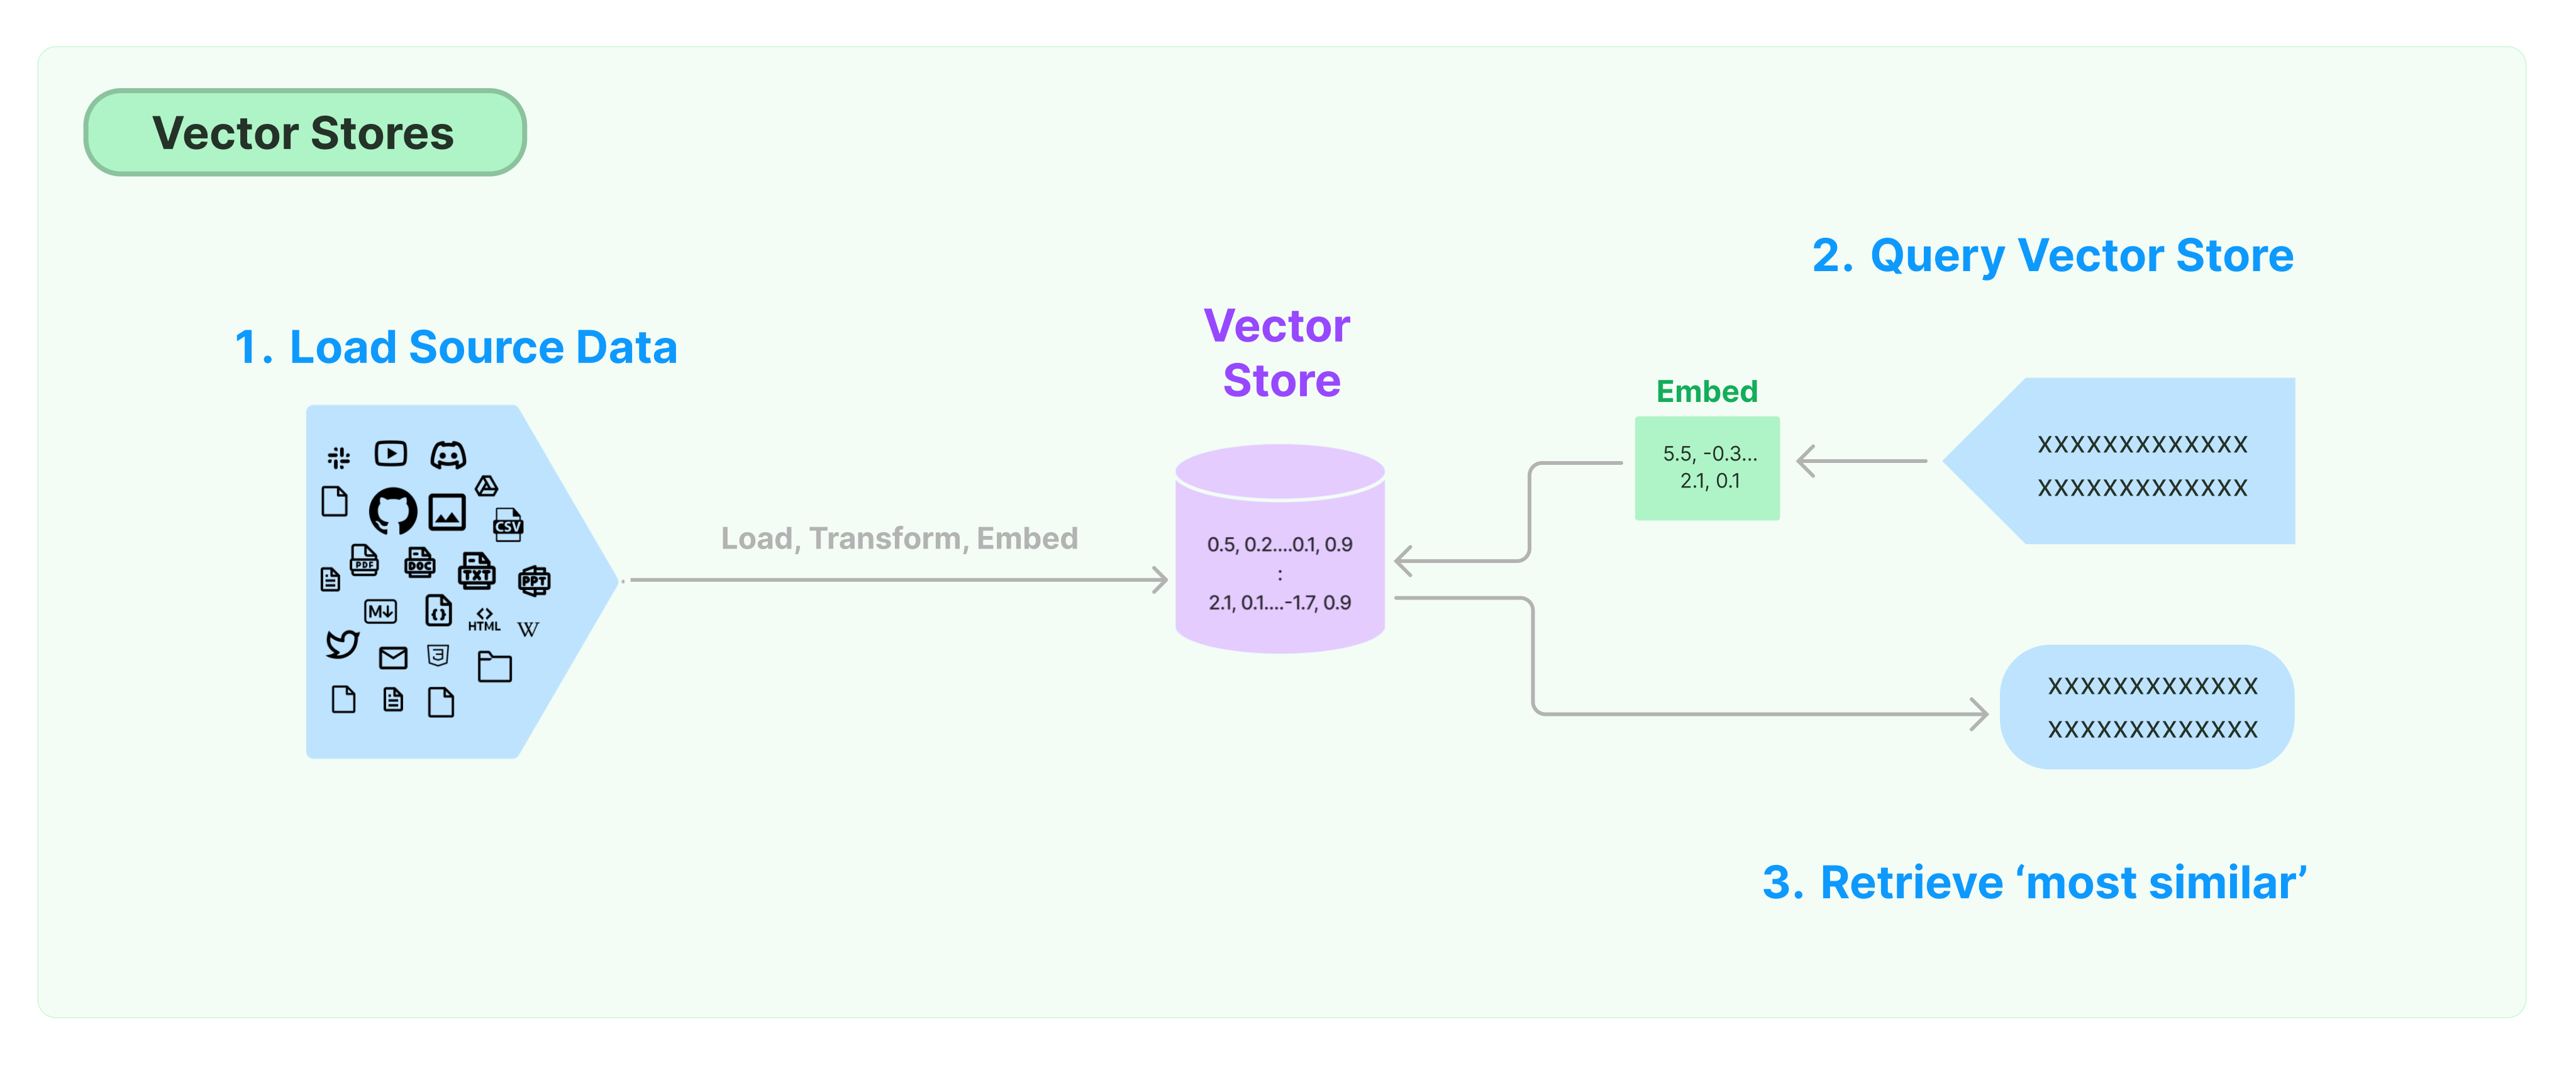

### 2.4.1 Chroma

In [ ]:
# Load the document, split it into chunks, embed each chunk and load it into the vector store.
raw_documents = TextLoader('/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt').load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents = text_splitter.split_documents(raw_documents)
db = Chroma.from_documents(documents, OpenAIEmbeddings())

KeyboardInterrupt: ignored

In [ ]:
query = "Susan Calvin"
docs = db.similarity_search(query)
print(docs[0].page_content)

In [ ]:
embedding_vector = OpenAIEmbeddings().embed_query(query)
docs = db.similarity_search_by_vector(embedding_vector)
print(docs[0].page_content)

### 2.4.2 FAISS

In [ ]:
db = FAISS.from_documents(documents, OpenAIEmbeddings())

In [ ]:
query = "Susan Calvin"
docs = db.similarity_search(query)
print(docs[0].page_content)

## 2.5. Retrievers

A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) it. Vector stores can be used as the backbone of a retriever, but there are other types of retrievers as well.

In [ ]:
# An example of question answering over documents.
# Question answering over documents consists of four steps:

# 1. Create an index
# 2. Create a Retriever from that index
# 3. Create a question answering chain
# 4. Ask questions!

In [ ]:
loader = TextLoader('/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt', encoding='utf8')

In [ ]:
index = VectorstoreIndexCreator().from_loaders([loader])

In [ ]:
query = "Who was Susan Calvin?"
index.query(query)

' Susan Calvin was a roboticist who obtained her bachelor\'s degree at Columbia in 2003 and began graduate work in cybernetics. She was known for her cold gray eyes and her ability to calculate the parameters necessary to fix the possible variables within the "positronic brain".'

In [ ]:
query = "Who was Susan Calvin?"
index.query_with_sources(query)

{'question': 'Who was Susan Calvin?',
 'answer': ' Susan Calvin was a frosty girl, plain and colorless, who obtained her bachelor\'s degree at Columbia in 2003 and began graduate work in cybernetics. She was a roboticist who specialized in calculating the parameters necessary to fix the possible variables within the "positronic brain".\n\n',
 'sources': '/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt'}

In [ ]:
# What is under the hood of VectorstoreIndexCreator? There are three main steps going on after the documents are loaded:

# 1. Splitting documents into chunks
# 2. Creating embeddings for each document
# 3. Storing documents and embeddings in a vectorstore

In [ ]:
documents = loader.load()

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

In [ ]:
embeddings = OpenAIEmbeddings()

In [ ]:
db = Chroma.from_documents(texts, embeddings)

In [ ]:
# So that's creating the index. Then, we expose this index in a retriever interface.

In [ ]:
retriever = db.as_retriever()

In [ ]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=retriever)

In [ ]:
query = "Who was Susan Calvin?"
qa.run(query)

' Susan Calvin was a seventy-five year old robot psychologist who was born in 1982. She was present at the Psycho-Math seminar at which Dr. Alfred Lanning of U. S. Robots demonstrated the first mobile robot to be equipped with a voice.'

In [ ]:
# VectorstoreIndexCreator is just a wrapper around all this logic. It is configurable in the text splitter it uses,
# the embeddings it uses, and the vectorstore it uses.

### 2.5.1. MultiQueryRetriever

The MultiQueryRetriever automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query. For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents. By generating multiple perspectives on the same question, the MultiQueryRetriever might be able to overcome some of the limitations of the distance-based retrieval and get a richer set of results.

In [ ]:
# Build a sample vectorDB

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

In [ ]:
question = "What are the approaches to Task Decomposition?"
llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

In [ ]:
# Set logging for the queries
logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [ ]:
unique_docs = retriever_from_llm.get_relevant_documents(query=question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. How can Task Decomposition be approached?', '2. What are the different methods for Task Decomposition?', '3. What are the various approaches to decomposing tasks?']


5

### 2.5.2. Contextual compression

One challenge with retrieval is that usually you don't know the specific queries your document storage system will face when you ingest data into the system. This means that the information most relevant to a query may be buried in a document with a lot of irrelevant text. Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. The idea is simple: instead of immediately returning retrieved documents as-is, you can compress them using the context of the given query, so that only the relevant information is returned.
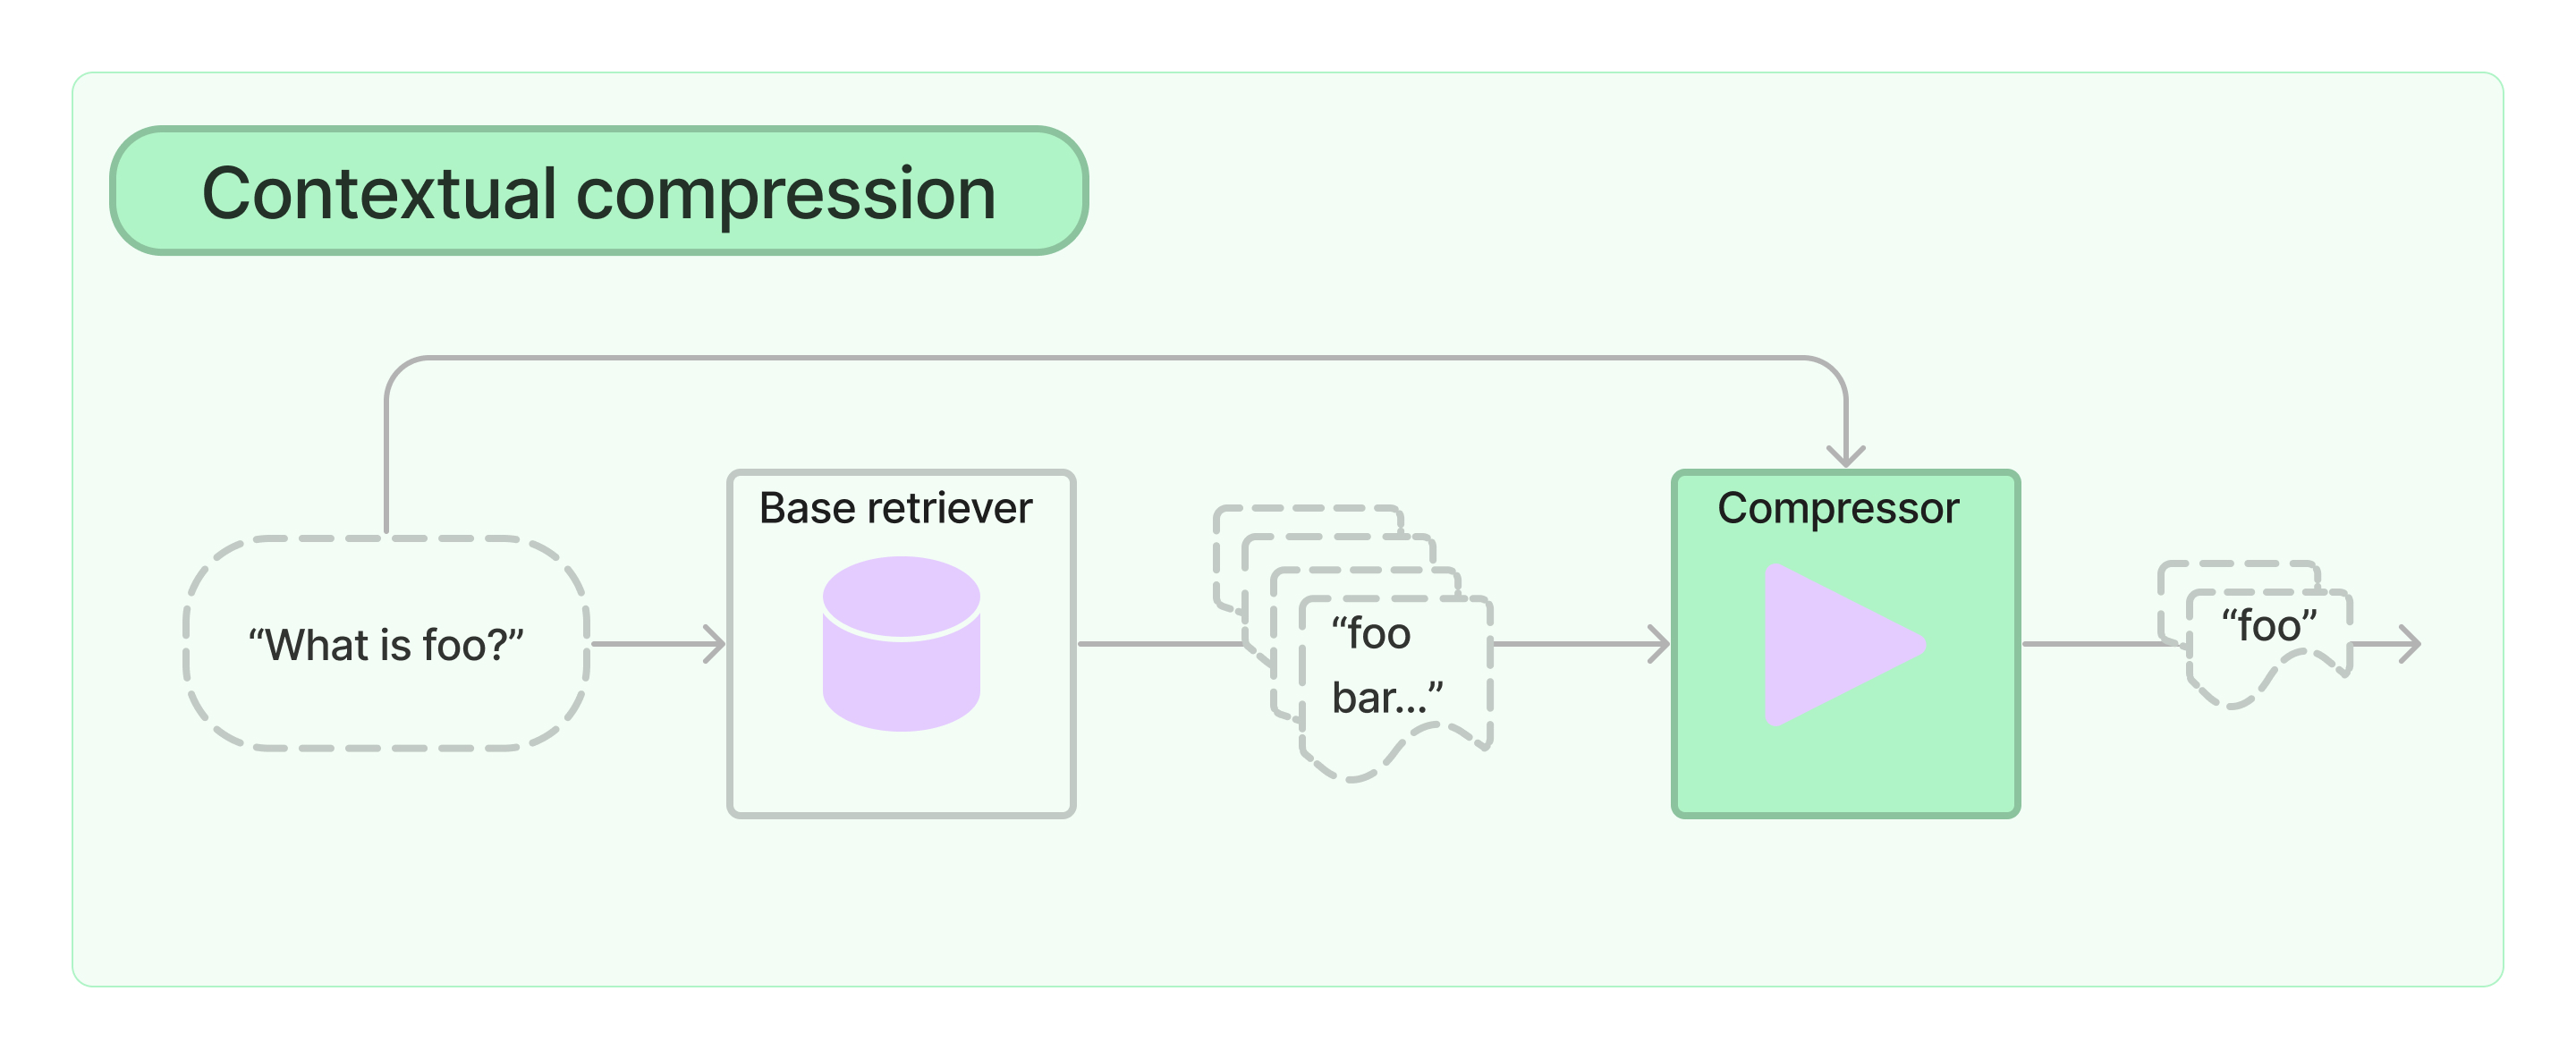

In [ ]:
# Helper function for printing docs

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

In [ ]:
documents = TextLoader('/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt').load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
retriever = FAISS.from_documents(texts, OpenAIEmbeddings()).as_retriever()

# Our retriever returns one or two relevant docs and a few irrelevant docs. And even the relevant docs have a lot of irrelevant information in them.
docs = retriever.get_relevant_documents("Who was Susan Calvin?")
pretty_print_docs(docs)

Document 1:

WHEN I DID SEE SUSAN CALVIN AGAIN, IT WAS AT the door of her office. Files were being moved out.

She said, "How are your articles coming along, young man?"

"Fine," I said. I had put them into shape according to my own lights, dramatized the bare bones of her recital, added the conversation and little touches, "Would you look over them and see if I haven't been libellous or too unreasonably inaccurate anywhere?"

"I suppose so. Shall we retire to the Executives' Lounge? We can have coffee."

She seemed in good humor, so I chanced it as we walked down the corridor, "I was wondering, Dr. Calvin-"

"Yes?"

"If you would tell me more concerning the history of robotics."

"Surely you have what you want, young man."
----------------------------------------------------------------------------------------------------
Document 2:

But Susan Calvin whirled on him now and the hunted pain in her eyes became a blaze, "Why should I? What do you know about it all, anyway, you� you machi

In [ ]:
llm = OpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("Who was Susan Calvin?")
pretty_print_docs(compressed_docs)

/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:275: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

"How are your articles coming along, young man?" "I was wondering, Dr. Calvin-"
----------------------------------------------------------------------------------------------------
Document 2:

"But Susan Calvin whirled on him now and the hunted pain in her eyes became a blaze, "Why should I? What do you know about it all, anyway, you� you machine. I'm just a specimen to you; an interesting bug with a peculiar mind spread-eagled for inspection."
----------------------------------------------------------------------------------------------------
Document 3:

Susan Calvin had been born in the year 1982, they said, which made her seventy-five now. At the age of twenty, Susan Calvin had been part of the particular Psycho-Math seminar at which Dr. Alfred Lanning of U. S. Robots had demonstrated the first mobile robot to be equipped with a voice.
----------------------------------------------------------------------------------------------------
Document 4:

Susan Calvin was a f

### 2.5.3.Time-weighted vector store retriever

This retriever uses a combination of semantic similarity and a time decay.

The algorithm for scoring them is:

semantic_similarity + (1.0 - decay_rate) ^ hours_passed

Notably, hours_passed refers to the hours passed since the object in the retriever was last accessed, not since it was created. This means that frequently accessed objects remain "fresh."

### 2.5.4. Vector store-backed retriever

A vector store retriever is a retriever that uses a vector store to retrieve documents. It is a lightweight wrapper around the Vector Store class to make it conform to the Retriever interface. It uses the search methods implemented by a vector store, like similarity search and MMR, to query the texts in the vector store.

In [ ]:
loader = TextLoader('/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt')

In [ ]:
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(texts, embeddings)

In [ ]:
retriever = db.as_retriever()

In [ ]:
docs = retriever.get_relevant_documents("Who is Susan Calvin?")
pretty_print_docs(docs)

Document 1:

WHEN I DID SEE SUSAN CALVIN AGAIN, IT WAS AT the door of her office. Files were being moved out.

She said, "How are your articles coming along, young man?"

"Fine," I said. I had put them into shape according to my own lights, dramatized the bare bones of her recital, added the conversation and little touches, "Would you look over them and see if I haven't been libellous or too unreasonably inaccurate anywhere?"

"I suppose so. Shall we retire to the Executives' Lounge? We can have coffee."

She seemed in good humor, so I chanced it as we walked down the corridor, "I was wondering, Dr. Calvin-"

"Yes?"

"If you would tell me more concerning the history of robotics."

"Surely you have what you want, young man."
----------------------------------------------------------------------------------------------------
Document 2:

"If we're going to start by trying to fix the blame on one another, I'm leaving." Susan Calvin's hands were folded tightly in her lap, and the little li

In [ ]:
# Maximum Marginal Relevance Retrieval
retriever = db.as_retriever(search_type="mmr")
docs = retriever.get_relevant_documents("Who is Susan Calvin?")
pretty_print_docs(docs)

Document 1:

WHEN I DID SEE SUSAN CALVIN AGAIN, IT WAS AT the door of her office. Files were being moved out.

She said, "How are your articles coming along, young man?"

"Fine," I said. I had put them into shape according to my own lights, dramatized the bare bones of her recital, added the conversation and little touches, "Would you look over them and see if I haven't been libellous or too unreasonably inaccurate anywhere?"

"I suppose so. Shall we retire to the Executives' Lounge? We can have coffee."

She seemed in good humor, so I chanced it as we walked down the corridor, "I was wondering, Dr. Calvin-"

"Yes?"

"If you would tell me more concerning the history of robotics."

"Surely you have what you want, young man."
----------------------------------------------------------------------------------------------------
Document 2:

Susan said nothing at that seminar; took no part in the hectic discussion period that followed. She was a frosty girl, plain and colorless, who protecte

In [ ]:
# Similarity Score Threshold Retrieval
retriever = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": .5})
docs = retriever.get_relevant_documents("Who is Susan Calvin?")
pretty_print_docs(docs)

Document 1:

WHEN I DID SEE SUSAN CALVIN AGAIN, IT WAS AT the door of her office. Files were being moved out.

She said, "How are your articles coming along, young man?"

"Fine," I said. I had put them into shape according to my own lights, dramatized the bare bones of her recital, added the conversation and little touches, "Would you look over them and see if I haven't been libellous or too unreasonably inaccurate anywhere?"

"I suppose so. Shall we retire to the Executives' Lounge? We can have coffee."

She seemed in good humor, so I chanced it as we walked down the corridor, "I was wondering, Dr. Calvin-"

"Yes?"

"If you would tell me more concerning the history of robotics."

"Surely you have what you want, young man."
----------------------------------------------------------------------------------------------------
Document 2:

"If we're going to start by trying to fix the blame on one another, I'm leaving." Susan Calvin's hands were folded tightly in her lap, and the little li

In [ ]:
# Specifying top k
retriever = db.as_retriever(search_kwargs={"k": 1})
docs = retriever.get_relevant_documents("Who is Susan Calvin?")
pretty_print_docs(docs)

Document 1:

WHEN I DID SEE SUSAN CALVIN AGAIN, IT WAS AT the door of her office. Files were being moved out.

She said, "How are your articles coming along, young man?"

"Fine," I said. I had put them into shape according to my own lights, dramatized the bare bones of her recital, added the conversation and little touches, "Would you look over them and see if I haven't been libellous or too unreasonably inaccurate anywhere?"

"I suppose so. Shall we retire to the Executives' Lounge? We can have coffee."

She seemed in good humor, so I chanced it as we walked down the corridor, "I was wondering, Dr. Calvin-"

"Yes?"

"If you would tell me more concerning the history of robotics."

"Surely you have what you want, young man."


# 3. Chains

Using an LLM in isolation is fine for simple applications, but more complex applications require chaining LLMs - either with each other or with other components.

## 3.1. LLM
An LLMChain consists of a PromptTemplate and a language model (either an LLM or chat model)

In [6]:
prompt_template = "What is a good name for a company that makes {product}?"

llm = OpenAI(temperature=0)
llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)
llm_chain("colorful socks")

{'product': 'colorful socks', 'text': '\n\nSocktastic!'}

### 3.1.1. Additional ways of running LLM Chain

* apply allows you run the chain against a list of inputs:

In [7]:
input_list = [
    {"product": "socks"},
    {"product": "computer"},
    {"product": "shoes"}
]

llm_chain.apply(input_list)

[{'text': '\n\nSocktastic!'},
 {'text': '\n\nTechCore Solutions.'},
 {'text': '\n\nFootwear Factory.'}]

* generate is similar to apply, except it return an LLMResult instead of string. LLMResult often contains useful generation such as token usages and finish reason.


In [8]:
llm_chain.generate(input_list)

LLMResult(generations=[[Generation(text='\n\nSocktastic!', generation_info={'finish_reason': 'stop', 'logprobs': None})], [Generation(text='\n\nTechCore Solutions.', generation_info={'finish_reason': 'stop', 'logprobs': None})], [Generation(text='\n\nFootwear Factory.', generation_info={'finish_reason': 'stop', 'logprobs': None})]], llm_output={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 36, 'total_tokens': 55}, 'model_name': 'text-davinci-003'}, run=[RunInfo(run_id=UUID('c001f73a-d687-4c54-a064-dd3d9aa5a5e0')), RunInfo(run_id=UUID('ae96cefb-0ded-4ca1-85be-b7c4f882a797')), RunInfo(run_id=UUID('df6de6cb-753d-49d1-b75d-00d70899f8e2'))])

* predict is similar to run method except that the input keys are specified as keyword arguments instead of a Python dict.

In [10]:
llm_chain.predict(product="colorful socks")

'\n\nSocktastic!'

In [13]:
template = """Tell me a {adjective} joke about {subject}."""
prompt = PromptTemplate(template=template, input_variables=["adjective", "subject"])
llm_chain = LLMChain(prompt=prompt, llm=OpenAI(temperature=0))

llm_chain.predict(adjective="sad", subject="ducks")

'\n\nQ: What did the duck say when his friend died?\nA: Quack, quack, goodbye.'

### 3.1.2. Parsing the outputs

By default, LLMChain does not parse the output even if the underlying prompt object has an output parser. If you would like to apply that output parser on the LLM output, use predict_and_parse instead of predict and apply_and_parse instead of apply.

In [14]:
output_parser = CommaSeparatedListOutputParser()
template = """List all the colors in a rainbow"""
prompt = PromptTemplate(template=template, input_variables=[], output_parser=output_parser)
llm_chain = LLMChain(prompt=prompt, llm=llm)

llm_chain.predict()

'\n\nRed, orange, yellow, green, blue, indigo, violet'

In [15]:
llm_chain.predict_and_parse()

/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:279: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


['Red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']

## 3.2. Router

Router chains are made up of two components:

The RouterChain itself (responsible for selecting the next chain to call)
destination_chains: chains that the router chain can route to

In [16]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{input}"""

In [17]:
prompt_infos = [
    {
        "name": "physics",
        "description": "Good for answering questions about physics",
        "prompt_template": physics_template,
    },
    {
        "name": "math",
        "description": "Good for answering math questions",
        "prompt_template": math_template,
    },
]

In [21]:
llm = OpenAI()

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = PromptTemplate(template=prompt_template, input_variables=["input"])
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain

default_chain = ConversationChain(llm=llm, output_key="text")

### 3.2.1. LLMRouterChain

This chain uses an LLM to determine how to route things.

In [29]:
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(destinations=destinations_str)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)
router_chain = LLMRouterChain.from_llm(llm, router_prompt, verbose=True)

In [26]:
print(router_template)

Given a raw text input to a language model select the model prompt best suited for the input. You will be given the names of the available prompts and a description of what the prompt is best suited for. You may also revise the original input if you think that revising it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}
```

REMEMBER: "destination" MUST be one of the candidate prompt names specified below OR it can be "DEFAULT" if the input is not well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
physics: Good for answering questions about physics
math: Good for answering math questions

<< INPUT

In [30]:
chain = MultiPromptChain(
    router_chain=router_chain,
    destination_chains=destination_chains,
    default_chain=default_chain,
    verbose=True,
)

In [31]:
print(chain.run("What is black body radiation?"))



> Entering new MultiPromptChain chain...


> Entering new LLMRouterChain chain...

> Finished chain.
physics: {'input': 'What is black body radiation?'}

> Entering new LLMChain chain...
Prompt after formatting:
You are a very smart physics professor. You are great at answering questions about physics in a concise and easy to understand manner. When you don't know the answer to a question you admit that you don't know.

Here is a question:
What is black body radiation?

> Finished chain.

> Finished chain.


Black body radiation is the electromagnetic radiation that is emitted by an idealized physical body that has absorbed all radiation incident upon it. It is a type of thermal radiation and is described by Planck's law. Black body radiation is the thermal energy that is emitted by a perfectly absorbing and perfectly emitting material, such as a black hole. The radiation is a result of the thermal motion of the particles that make up the body.


In [32]:
print(
    chain.run(
        "What is the first prime number greater than 40 such that one plus the prime number is divisible by 3"
    )
)



> Entering new MultiPromptChain chain...


> Entering new LLMRouterChain chain...

> Finished chain.
math: {'input': 'What is the first prime number greater than 40 such that one plus the prime number is divisible by 3'}

> Entering new LLMChain chain...
Prompt after formatting:
You are a very good mathematician. You are great at answering math questions. You are so good because you are able to break down hard problems into their component parts, answer the component parts, and then put them together to answer the broader question.

Here is a question:
What is the first prime number greater than 40 such that one plus the prime number is divisible by 3

> Finished chain.

> Finished chain.
?

The answer is 43. When we add 1 to 43, we get 44, which is divisible by 3.


### 3.2.2. EmbeddingRouterChain

In [34]:
names_and_descriptions = [
    ("physics", ["for questions about physics"]),
    ("math", ["for questions about math"]),
]

In [39]:
router_chain = EmbeddingRouterChain.from_names_and_descriptions(
    names_and_descriptions, Chroma, OpenAIEmbeddings(), routing_keys=["input"], verbose=True
)

In [40]:
chain = MultiPromptChain(
    router_chain=router_chain,
    destination_chains=destination_chains,
    default_chain=default_chain,
    verbose=True,
)

In [41]:
print(chain.run("What is black body radiation?"))



> Entering new MultiPromptChain chain...


> Entering new EmbeddingRouterChain chain...

> Finished chain.
physics: {'input': 'What is black body radiation?'}

> Entering new LLMChain chain...
Prompt after formatting:
You are a very smart physics professor. You are great at answering questions about physics in a concise and easy to understand manner. When you don't know the answer to a question you admit that you don't know.

Here is a question:
What is black body radiation?

> Finished chain.

> Finished chain.


Black body radiation is the electromagnetic radiation emitted by a “black body”, an idealized physical body that absorbs all incident electromagnetic radiation. It is a type of thermal radiation, and is usually considered to be a uniform temperature at equilibrium. The spectrum of black body radiation is determined by the temperature of the body, and is a function of the body's surface area. The intensity of the radiation increases with increasing temperature, and the peak 

In [43]:
print(
    chain.run(
        "What is the first prime number greater than 40 such that one plus the prime number is divisible by 3"
    )
)



> Entering new MultiPromptChain chain...


> Entering new EmbeddingRouterChain chain...

> Finished chain.
math: {'input': 'What is the first prime number greater than 40 such that one plus the prime number is divisible by 3'}

> Entering new LLMChain chain...
Prompt after formatting:
You are a very good mathematician. You are great at answering math questions. You are so good because you are able to break down hard problems into their component parts, answer the component parts, and then put them together to answer the broader question.

Here is a question:
What is the first prime number greater than 40 such that one plus the prime number is divisible by 3

> Finished chain.

> Finished chain.
?

The first prime number greater than 40 such that one plus the prime number is divisible by 3 is 43. To answer this, we can look at the prime numbers greater than 40 and determine which one plus it is divisible by 3. The prime numbers greater than 40 are 41, 43, 47, 53, 59, 61, 67, 71, 73, 7

## 3.3. Sequential

The next step after calling a language model is make a series of calls to a language model. This is particularly useful when you want to take the output from one call and use it as the input to another.

In [44]:
llm = OpenAI(temperature=.7)
template = """You are a playwright. Given the title of play, it is your job to write a synopsis for that title.

Title: {title}
Playwright: This is a synopsis for the above play:"""
prompt_template = PromptTemplate(input_variables=["title"], template=template)
synopsis_chain = LLMChain(llm=llm, prompt=prompt_template)

In [46]:
llm = OpenAI(temperature=.7)
template = """You are a play critic from the New York Times. Given the synopsis of play, it is your job to write a review for that play.

Play Synopsis:
{synopsis}
Review from a New York Times play critic of the above play:"""
prompt_template = PromptTemplate(input_variables=["synopsis"], template=template)
review_chain = LLMChain(llm=llm, prompt=prompt_template)

In [47]:
# This is the overall chain where we run these two chains in sequence.
overall_chain = SimpleSequentialChain(chains=[synopsis_chain, review_chain], verbose=True)

In [48]:
review = overall_chain.run("Tragedy at sunset on the beach")



> Entering new SimpleSequentialChain chain...


Tragedy at Sunset on the Beach is a story of a young woman's struggles as she attempts to find her place in the world. The play follows the protagonist, a young woman named Jenny, as she navigates the fast-paced life of her beachside town. Despite her best efforts, Jenny finds herself at odds with the people around her, struggling to make meaningful connections and struggling to find her place in the world. As tensions grow, Jenny finds herself in a downward spiral of despair that leads her to a tragic end at the beach at sunset. Throughout the play, Jenny's struggles are mirrored in the lives of those around her, showing how human connections can be both fragile and powerful. Tragedy at Sunset on the Beach is a powerful story of love, loss, and redemption that will stay with audiences long after the curtain closes.


Tragedy at Sunset on the Beach is a moving and powerful play that draws audiences in with its gripping narrative and com

More complex example

In [50]:
# This is an LLMChain to write a synopsis given a title of a play and the era it is set in.
llm = OpenAI(temperature=.7)
template = """You are a playwright. Given the title of play and the era it is set in, it is your job to write a synopsis for that title.

Title: {title}
Era: {era}
Playwright: This is a synopsis for the above play:"""
prompt_template = PromptTemplate(input_variables=["title", "era"], template=template)
synopsis_chain = LLMChain(llm=llm, prompt=prompt_template, output_key="synopsis")

In [51]:
# This is an LLMChain to write a review of a play given a synopsis.
llm = OpenAI(temperature=.7)
template = """You are a play critic from the New York Times. Given the synopsis of play, it is your job to write a review for that play.

Play Synopsis:
{synopsis}
Review from a New York Times play critic of the above play:"""
prompt_template = PromptTemplate(input_variables=["synopsis"], template=template)
review_chain = LLMChain(llm=llm, prompt=prompt_template, output_key="review")

In [53]:
# This is the overall chain where we run these two chains in sequence.
overall_chain = SequentialChain(
    chains=[synopsis_chain, review_chain],
    input_variables=["era", "title"],
    # Here we return multiple variables
    output_variables=["synopsis", "review"],
    verbose=True)

In [54]:
overall_chain({"title":"Tragedy at sunset on the beach", "era": "Victorian England"})



> Entering new SequentialChain chain...

> Finished chain.


{'title': 'Tragedy at sunset on the beach',
 'era': 'Victorian England',
 'synopsis': '\n\nTragedy at Sunset on the Beach is a dramatic play set in the Victorian era of England. It tells the story of a young couple, Emily and Jason, whose love for one another is forbidden. Emily is from a wealthy family, while Jason is an impoverished laborer. Despite the odds, they find solace in each other and their relationship blossoms. \n\nOne day, Emily’s father discovers the couple’s secret and forbids them from seeing each other. Heartbroken, Emily and Jason agree to a secret rendezvous at sunset on the beach. \n\nAt the beach, Emily and Jason are overcome with emotion and declare their undying love. As the sun sets, Emily’s father arrives and confronts the couple. In a fit of rage, he kills Jason in front of Emily. \n\nEmily is devastated and consumed with grief for the loss of her true love. She is unable to move on and over the course of the play, she slowly slips away from reality, eventual

Sometimes you may want to pass along some context to use in each step of the chain or in a later part of the chain. In this case we can use SimpleMemory

In [56]:
llm = OpenAI(temperature=.7)
template = """You are a social media manager for a theater company.  Given the title of play, the era it is set in, the date,time and location, the synopsis of the play, and the review of the play, it is your job to write a social media post for that play.

Here is some context about the time and location of the play:
Date and Time: {time}
Location: {location}

Play Synopsis:
{synopsis}
Review from a New York Times play critic of the above play:
{review}

Social Media Post:
"""
prompt_template = PromptTemplate(input_variables=["synopsis", "review", "time", "location"], template=template)
social_chain = LLMChain(llm=llm, prompt=prompt_template, output_key="social_post_text")

overall_chain = SequentialChain(
    memory=SimpleMemory(memories={"time": "December 25th, 8pm PST", "location": "Theater in the Park"}),
    chains=[synopsis_chain, review_chain, social_chain],
    input_variables=["era", "title"],
    # Here we can return multiple variables
    output_variables=["social_post_text"],
    verbose=True)

overall_chain({"title":"Tragedy at sunset on the beach", "era": "Victorian England"})



> Entering new SequentialChain chain...

> Finished chain.


{'title': 'Tragedy at sunset on the beach',
 'era': 'Victorian England',
 'time': 'December 25th, 8pm PST',
 'location': 'Theater in the Park',
 'social_post_text': '\nCome experience a powerful story of hope and tragedy at Theater in the Park! On December 25th, 8pm PST, join us for Tragedy at Sunset on the Beach, set in Victorian England. Follow a humble family of fishermen and their desperate hope for a better life. Will they be able to escape their fate or will tragedy befall them? Find out in this moving and powerful play that is sure to leave a lasting impression. Buy your tickets now! #TragedyAtSunsetOnTheBeach #VictorianEngland #TheaterInThePark'}

## 3.4. Other useful chains for working with documents

These are the core chains for working with Documents. They are useful for summarizing documents, answering questions over documents, extracting information from documents, and more.

### 3.4.1. Stuff
The stuff documents chain ("stuff" as in "to stuff" or "to fill") is the most straightforward of the document chains. It takes a list of documents, inserts them all into a prompt and passes that prompt to an LLM.

This chain is well-suited for applications where documents are small and only a few are passed in for most calls.

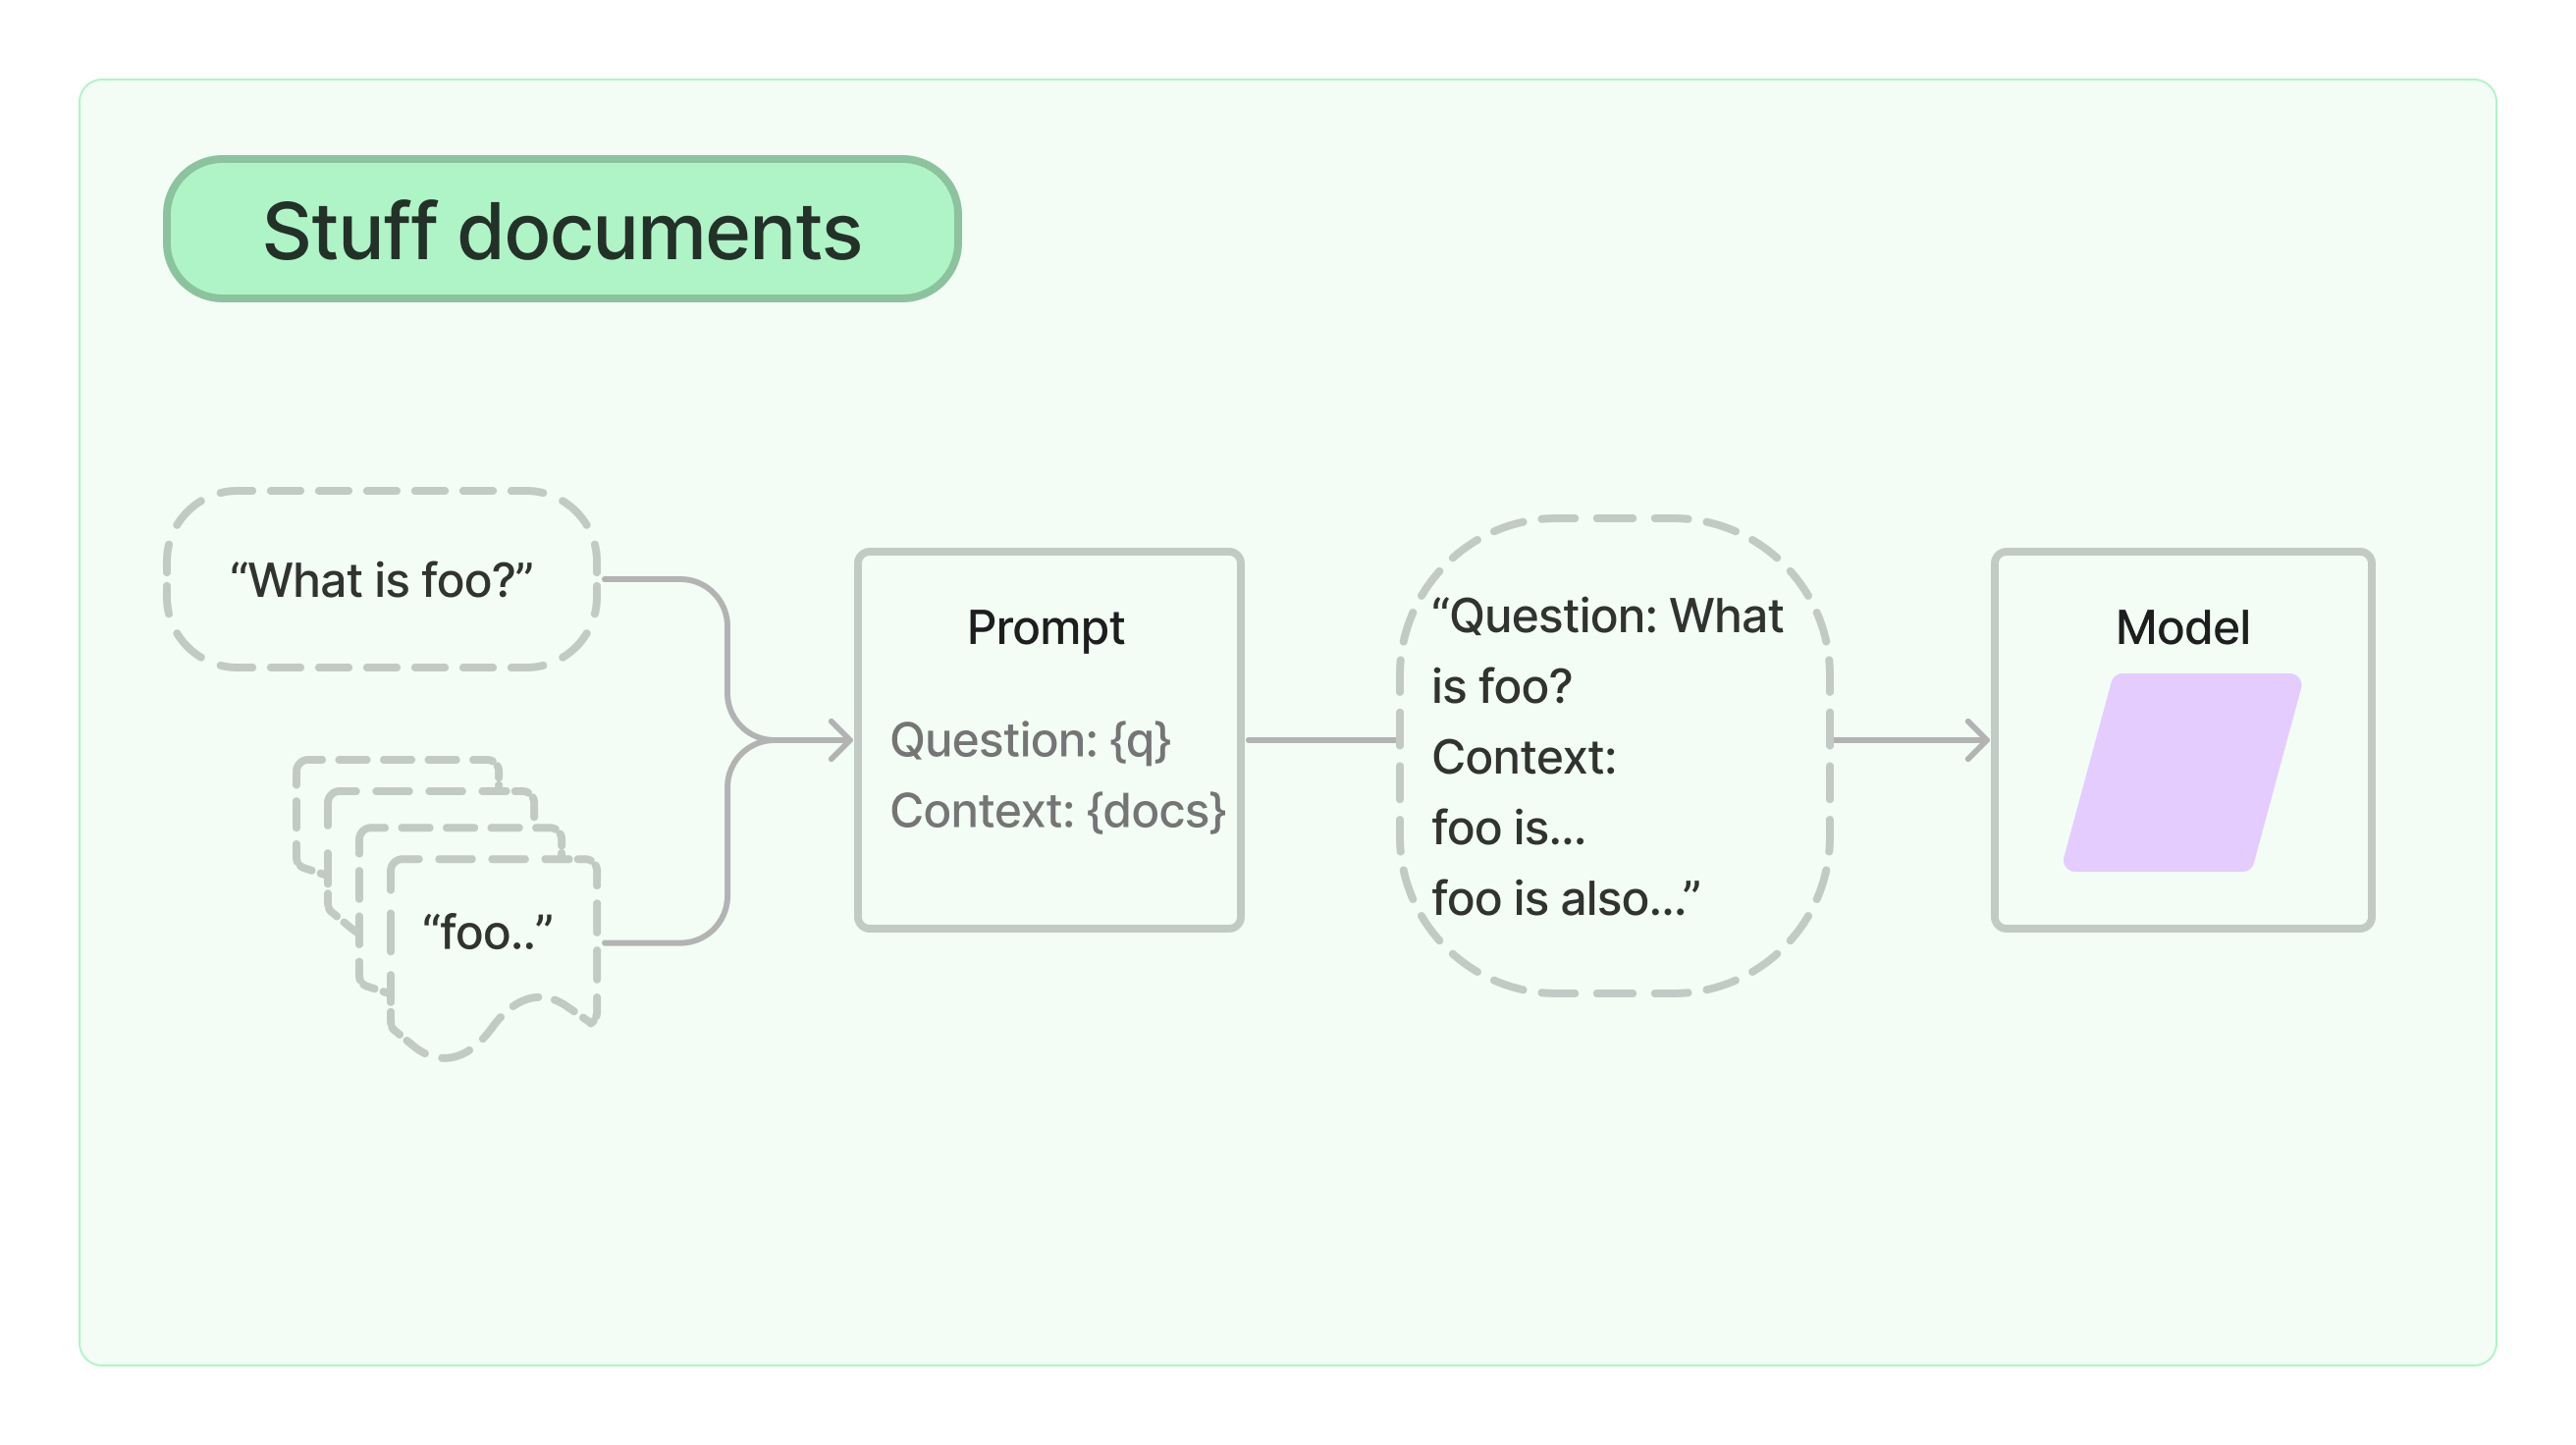

### 3.4.2. Refine

The refine documents chain constructs a response by looping over the input documents and iteratively updating its answer. For each document, it passes all non-document inputs, the current document, and the latest intermediate answer to an LLM chain to get a new answer.

Since the Refine chain only passes a single document to the LLM at a time, it is well-suited for tasks that require analyzing more documents than can fit in the model's context. The obvious tradeoff is that this chain will make far more LLM calls than, for example, the Stuff documents chain. There are also certain tasks which are difficult to accomplish iteratively. For example, the Refine chain can perform poorly when documents frequently cross-reference one another or when a task requires detailed information from many documents.

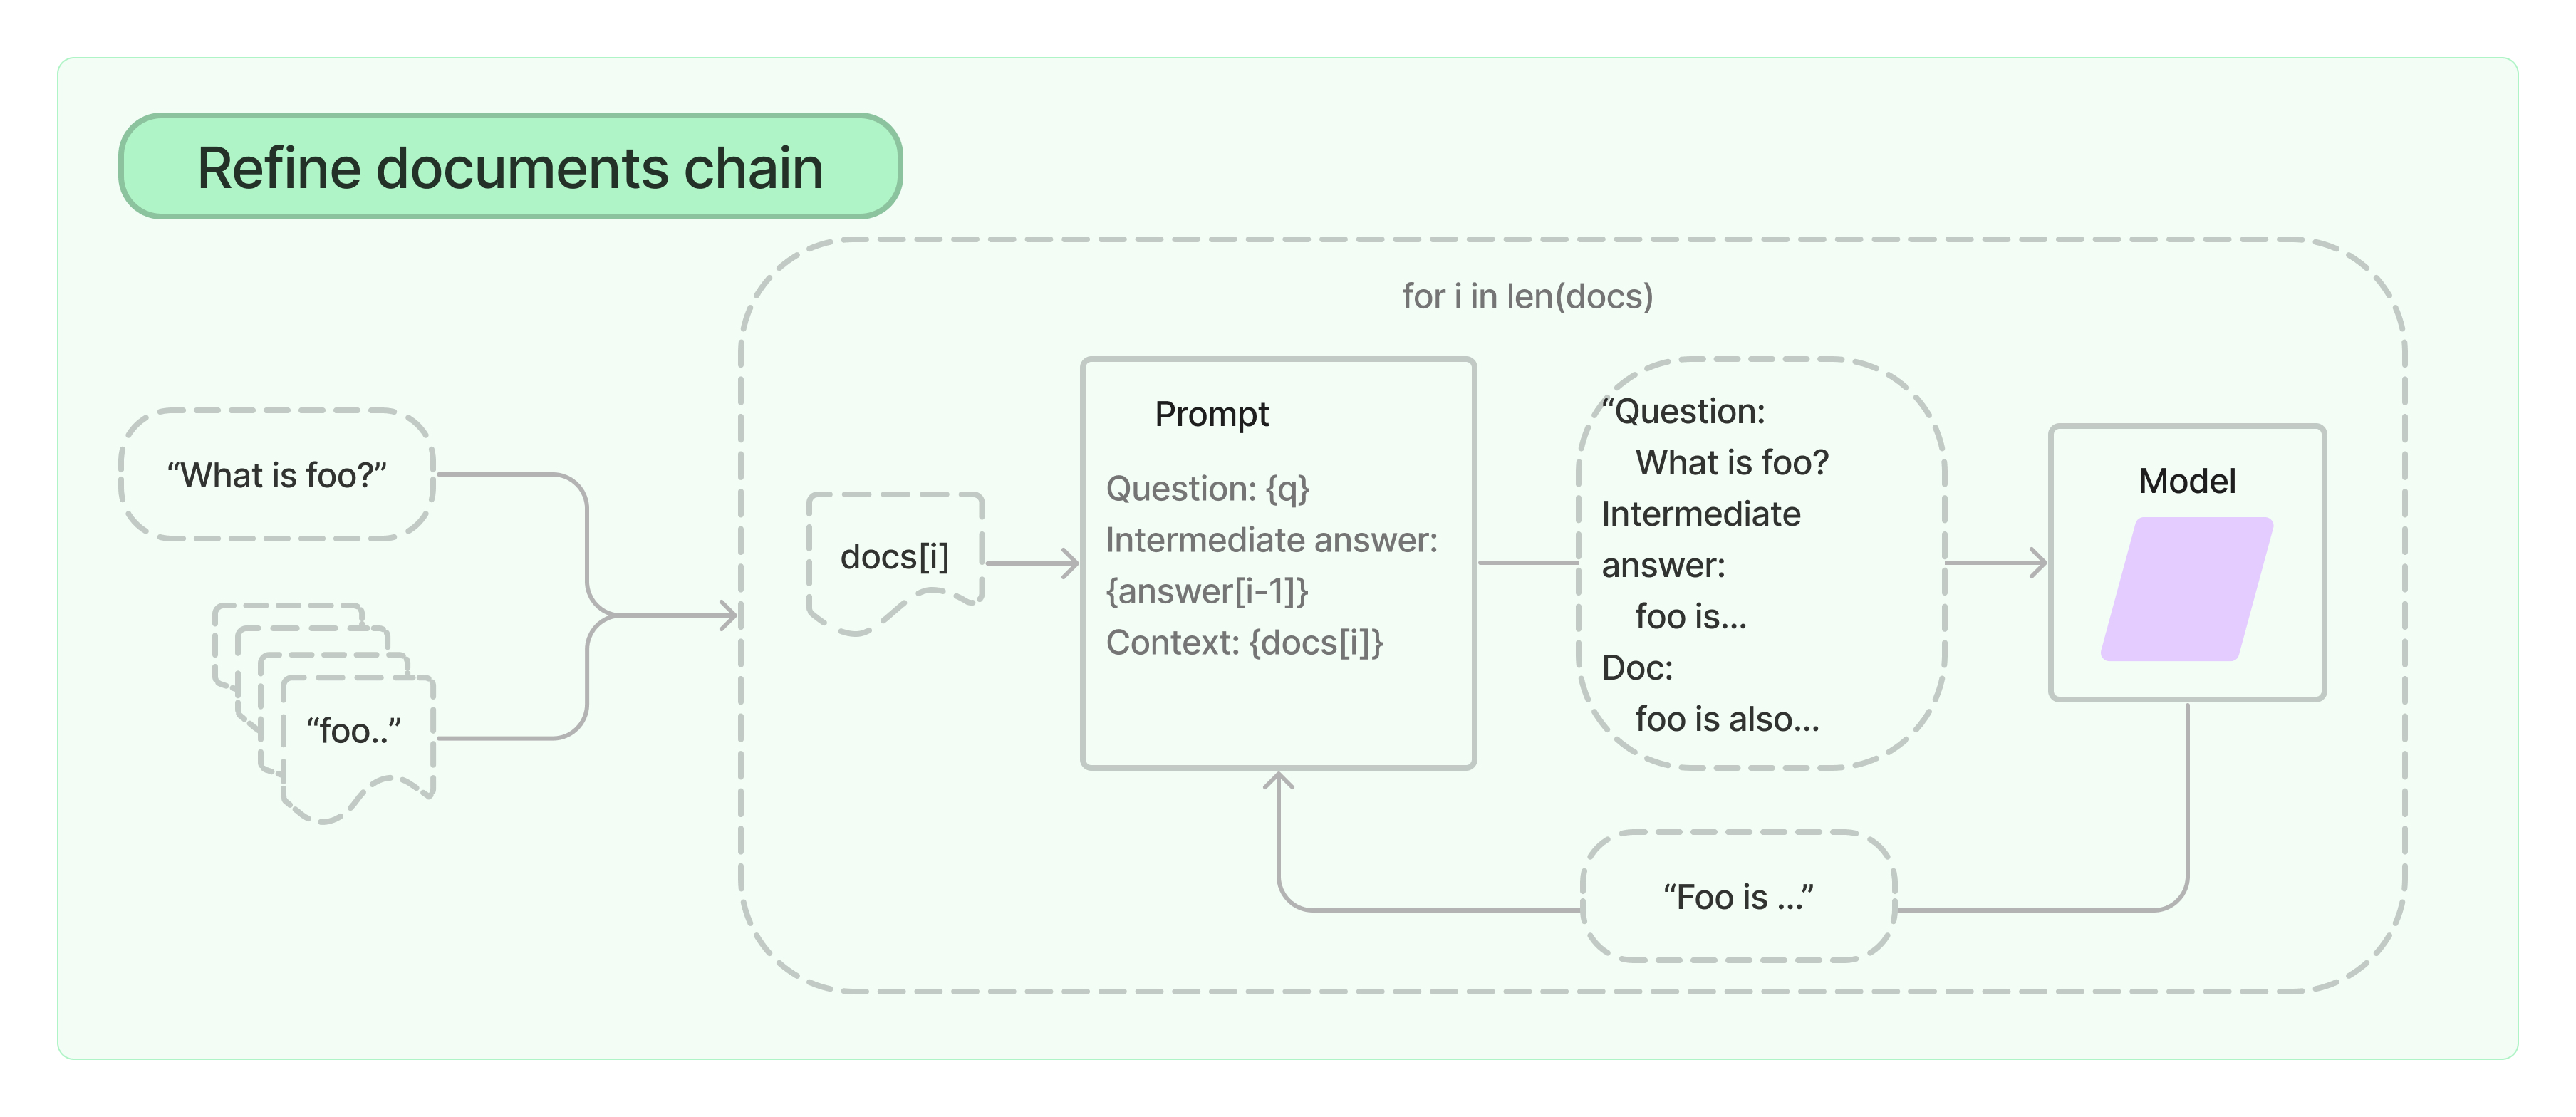

### 3.4.3 Map reduce

The map reduce documents chain first applies an LLM chain to each document individually (the Map step), treating the chain output as a new document. It then passes all the new documents to a separate combine documents chain to get a single output (the Reduce step). It can optionally first compress, or collapse, the mapped documents to make sure that they fit in the combine documents chain (which will often pass them to an LLM). This compression step is performed recursively if necessary.

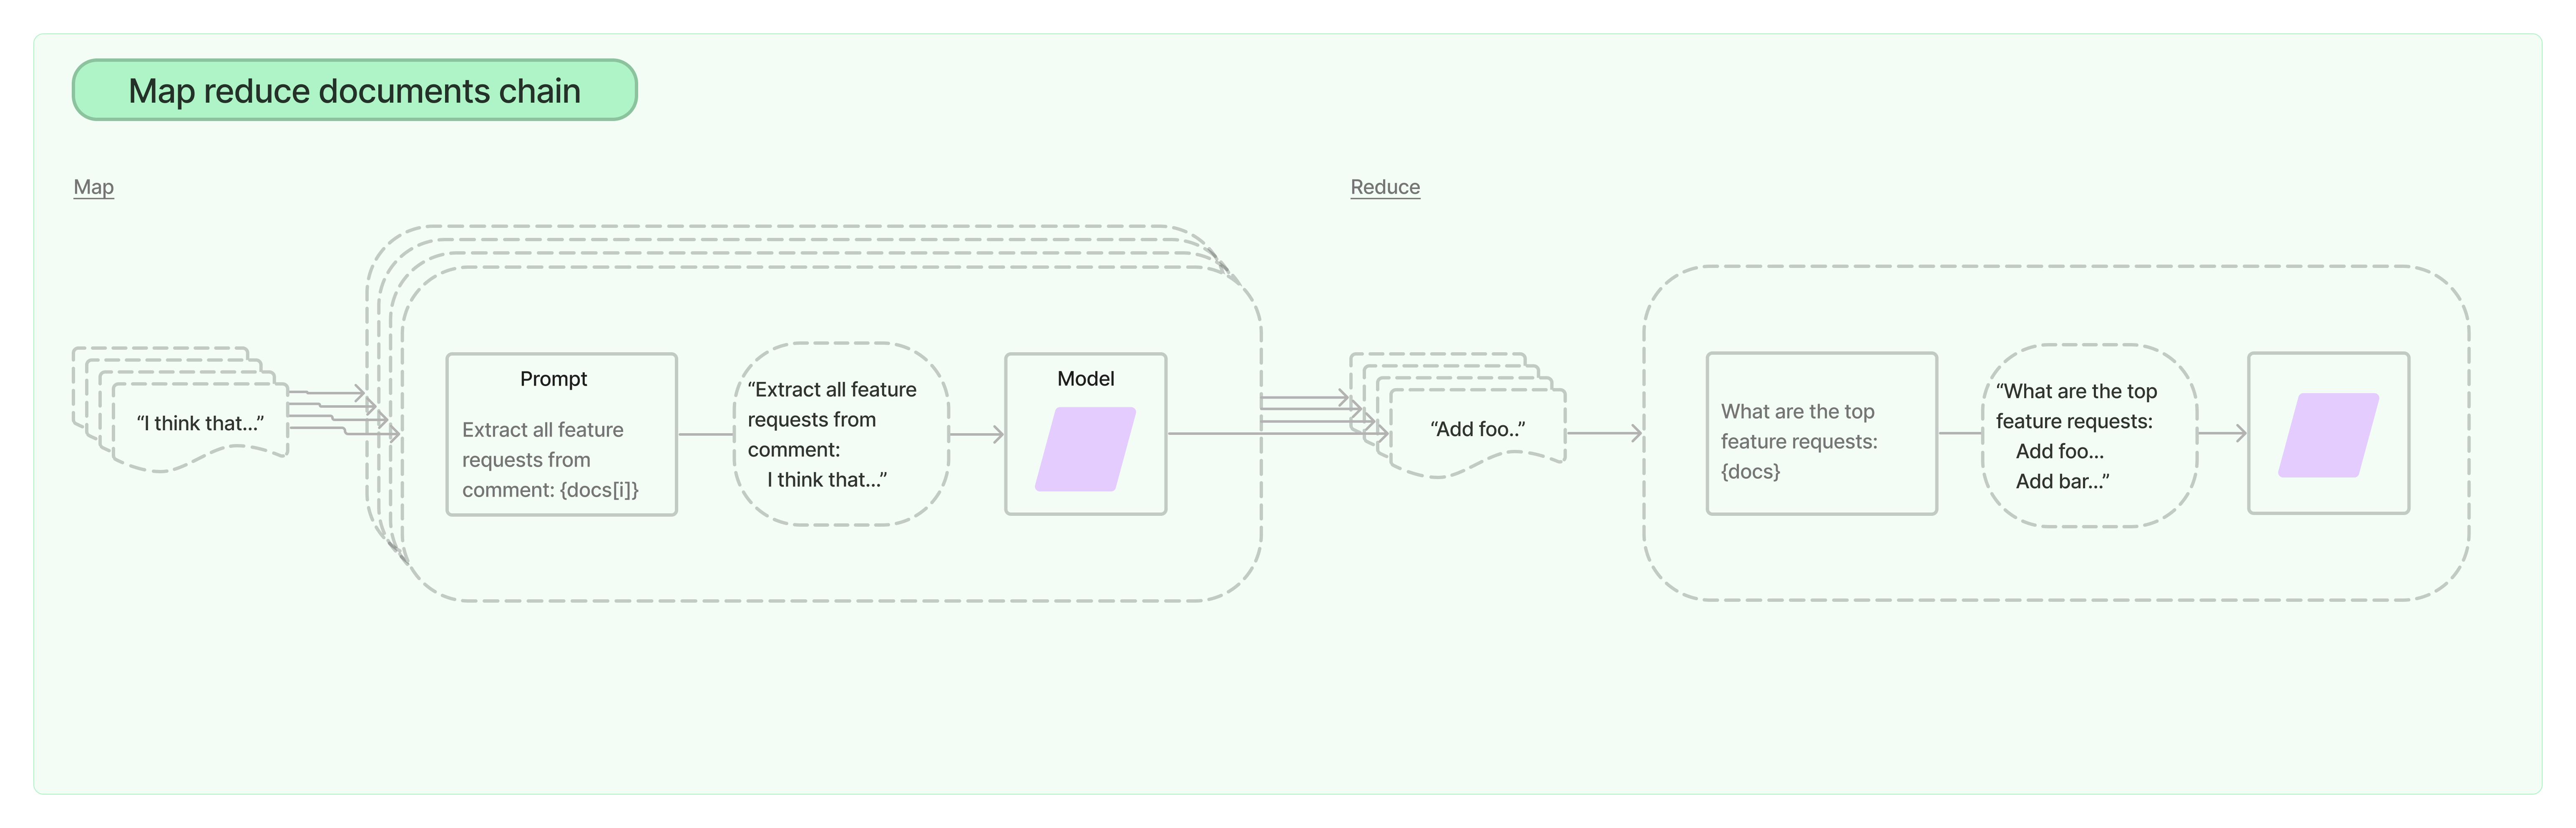

### 3.4.4. Map re-rank

The map re-rank documents chain runs an initial prompt on each document, that not only tries to complete a task but also gives a score for how certain it is in its answer. The highest scoring response is returned.

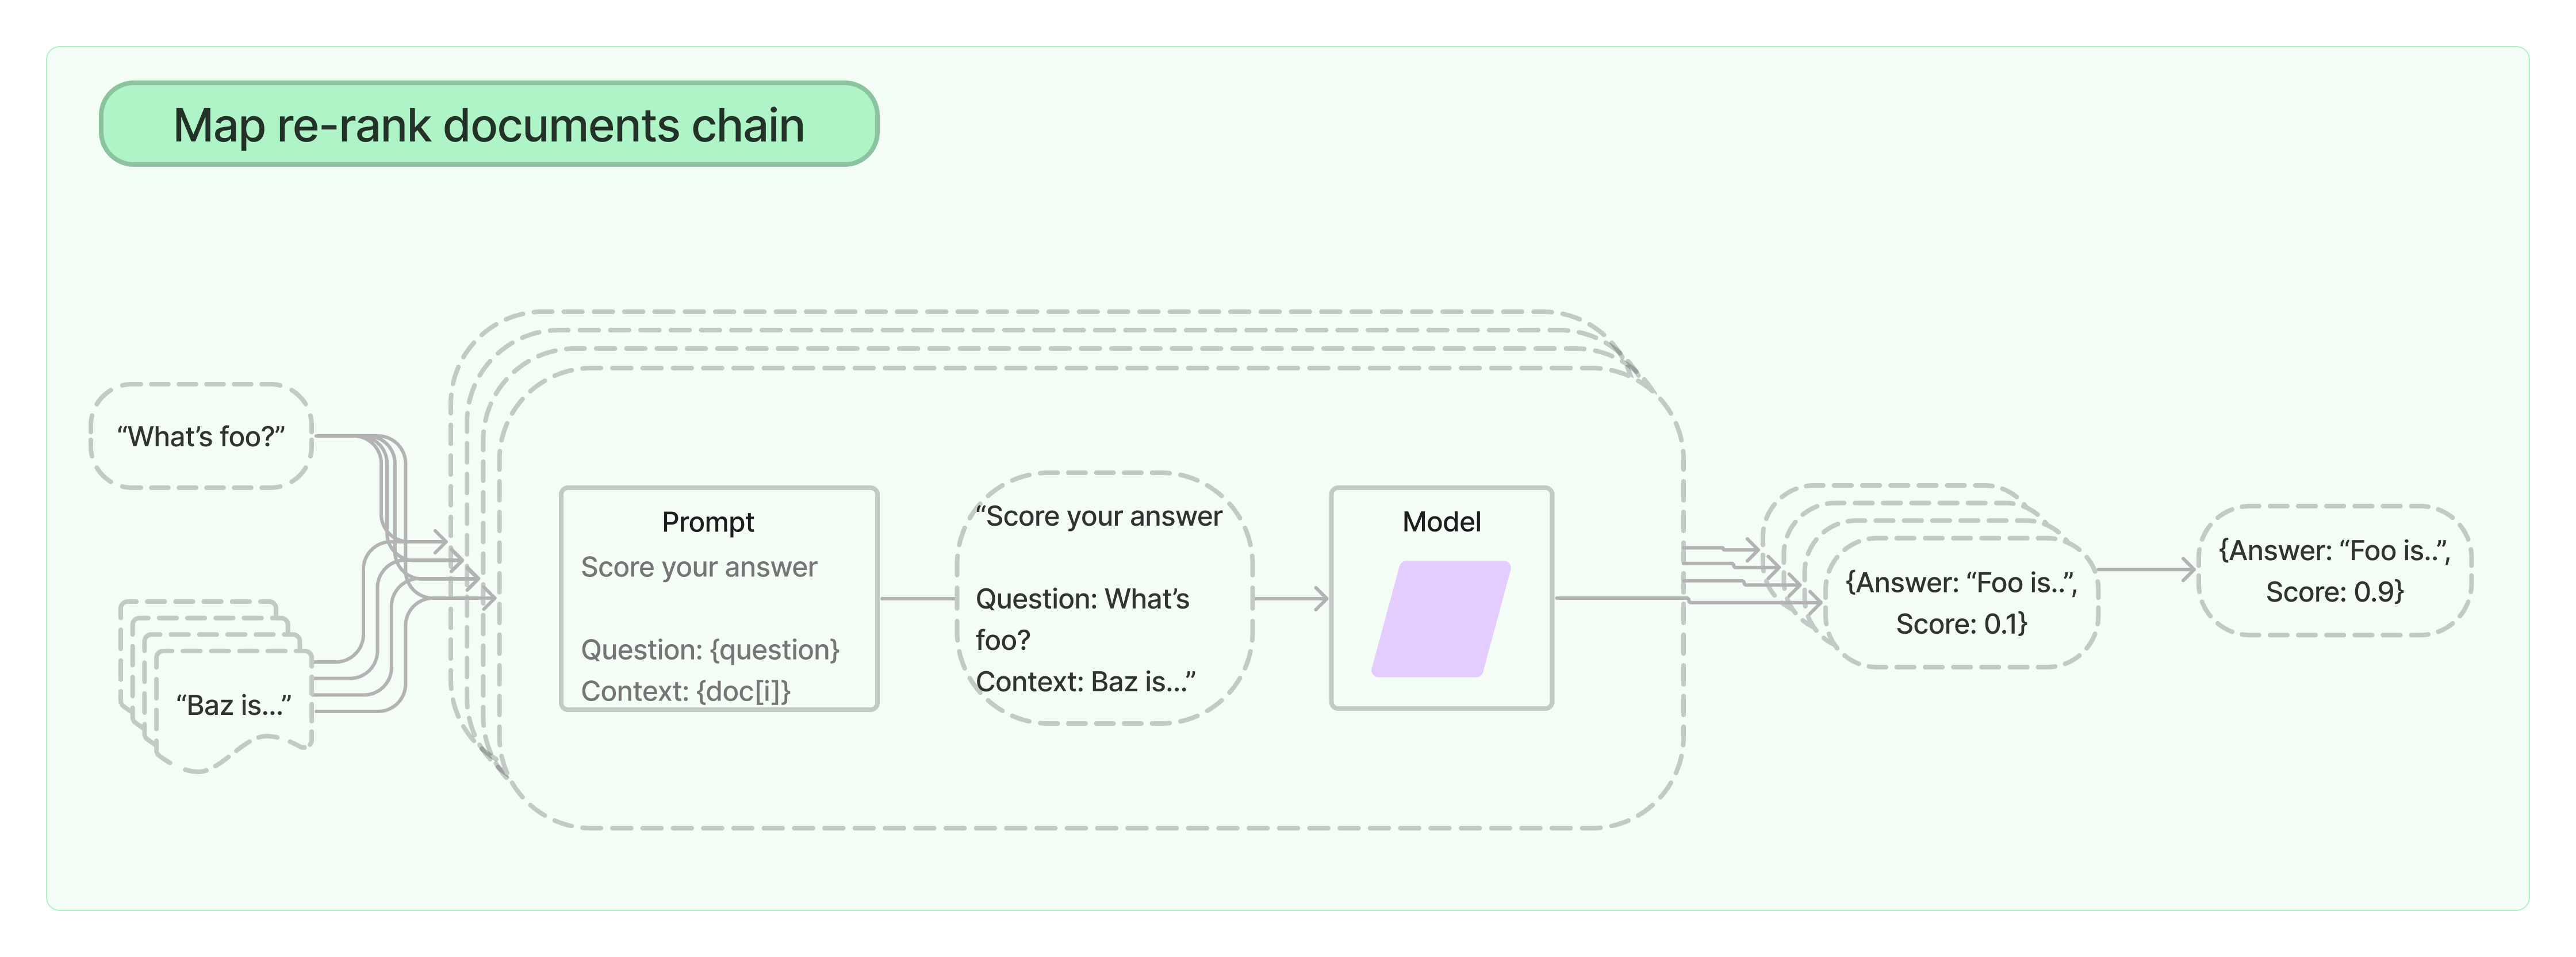

# 4. Memory

## 4.1. Memory Types

### 4.1.1. Conversation buffer memory

In [12]:
memory = ConversationBufferMemory()
memory.save_context({"input": "hi"}, {"output": "whats up"})

In [59]:
memory.load_memory_variables({})

{'history': 'Human: hi\nAI: whats up'}

In [60]:
memory = ConversationBufferMemory(return_messages=True)
memory.save_context({"input": "hi"}, {"output": "whats up"})

In [61]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='hi', additional_kwargs={}, example=False),
  AIMessage(content='whats up', additional_kwargs={}, example=False)]}

In [62]:
llm = OpenAI(temperature=0)
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferMemory()
)

In [63]:
conversation.predict(input="Hi there!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi there!
AI:

> Finished chain.


" Hi there! It's nice to meet you. How can I help you today?"

In [64]:
conversation.predict(input="I'm doing well! Just having a conversation with an AI.")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi there!
AI:  Hi there! It's nice to meet you. How can I help you today?
Human: I'm doing well! Just having a conversation with an AI.
AI:

> Finished chain.


" That's great! It's always nice to have a conversation with someone new. What would you like to talk about?"

In [65]:
conversation.predict(input="Tell me about yourself.")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi there!
AI:  Hi there! It's nice to meet you. How can I help you today?
Human: I'm doing well! Just having a conversation with an AI.
AI:  That's great! It's always nice to have a conversation with someone new. What would you like to talk about?
Human: Tell me about yourself.
AI:

> Finished chain.


" Sure! I'm an AI created to help people with their everyday tasks. I'm programmed to understand natural language and provide helpful information. I'm also constantly learning and updating my knowledge base so I can provide more accurate and helpful answers."

### 4.1.2 Conversation buffer window memory

In [68]:
memory = ConversationBufferWindowMemory(k=1)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.save_context({"input": "not much you"}, {"output": "not much"})
memory.load_memory_variables({})

{'history': 'Human: not much you\nAI: not much'}

In [69]:
memory = ConversationBufferWindowMemory( k=1, return_messages=True)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.save_context({"input": "not much you"}, {"output": "not much"})
memory.load_memory_variables({})

{'history': [HumanMessage(content='not much you', additional_kwargs={}, example=False),
  AIMessage(content='not much', additional_kwargs={}, example=False)]}

In [70]:
conversation_with_summary = ConversationChain(
    llm=OpenAI(temperature=0),
    # We set a low k=2, to only keep the last 2 interactions in memory
    memory=ConversationBufferWindowMemory(k=2),
    verbose=True
)
conversation_with_summary.predict(input="Hi, what's up?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, what's up?
AI:

> Finished chain.


" Hi there! I'm doing great. I'm currently helping a customer with a technical issue. How about you?"

In [71]:
conversation_with_summary.predict(input="What's their issues?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, what's up?
AI:  Hi there! I'm doing great. I'm currently helping a customer with a technical issue. How about you?
Human: What's their issues?
AI:

> Finished chain.


" The customer is having trouble connecting to their Wi-Fi network. I'm helping them troubleshoot the issue and get them connected."

In [72]:
conversation_with_summary.predict(input="Is it going well?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, what's up?
AI:  Hi there! I'm doing great. I'm currently helping a customer with a technical issue. How about you?
Human: What's their issues?
AI:  The customer is having trouble connecting to their Wi-Fi network. I'm helping them troubleshoot the issue and get them connected.
Human: Is it going well?
AI:

> Finished chain.


" Yes, it's going well so far. We've already identified the problem and are now working on a solution."

In [73]:
# Notice here that the first interaction does not appear.
conversation_with_summary.predict(input="What's the solution?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: What's their issues?
AI:  The customer is having trouble connecting to their Wi-Fi network. I'm helping them troubleshoot the issue and get them connected.
Human: Is it going well?
AI:  Yes, it's going well so far. We've already identified the problem and are now working on a solution.
Human: What's the solution?
AI:

> Finished chain.


" The solution is to reset the router and reconfigure the settings. We're currently in the process of doing that."

### 4.1.3. Entity memory

Entity Memory remembers given facts about specific entities in a conversation. It extracts information on entities (using an LLM) and builds up its knowledge about that entity over time (also using an LLM).

In [14]:
llm = OpenAI(temperature=0)

memory = ConversationEntityMemory(llm=llm)
_input = {"input": "Deven & Sam are working on a hackathon project"}
memory.load_memory_variables(_input)
memory.save_context(
    _input,
    {"output": " That sounds like a great project! What kind of project are they working on?"}
)

In [19]:
memory.load_memory_variables({"input": 'who is Sam'})

{'history': 'Human: Deven & Sam are working on a hackathon project\nAI:  That sounds like a great project! What kind of project are they working on?',
 'entities': {'Sam': 'Sam is working on a hackathon project with Deven.'}}

In [20]:
memory = ConversationEntityMemory(llm=llm, return_messages=True)
_input = {"input": "Deven & Sam are working on a hackathon project"}
memory.load_memory_variables(_input)
memory.save_context(
    _input,
    {"output": " That sounds like a great project! What kind of project are they working on?"}
)

In [21]:
memory.load_memory_variables({"input": 'who is Sam'})

{'history': [HumanMessage(content='Deven & Sam are working on a hackathon project', additional_kwargs={}, example=False),
  AIMessage(content=' That sounds like a great project! What kind of project are they working on?', additional_kwargs={}, example=False)],
 'entities': {'Sam': 'Sam is working on a hackathon project with Deven.'}}

In [26]:
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    prompt=ENTITY_MEMORY_CONVERSATION_TEMPLATE,
    memory=ConversationEntityMemory(llm=llm)
)

In [27]:
conversation.predict(input="Deven & Sam are working on a hackathon project")



> Entering new ConversationChain chain...
Prompt after formatting:
You are an assistant to a human, powered by a large language model trained by OpenAI.

You are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

You are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you receive, 

' That sounds like a great project! What kind of project are they working on?'

In [28]:
conversation.memory.entity_store.store

{'Deven': 'Deven is working on a hackathon project with Sam.',
 'Sam': 'Sam is working on a hackathon project with Deven.'}

In [29]:
conversation.predict(input="They are trying to add more complex memory structures to Langchain")



> Entering new ConversationChain chain...
Prompt after formatting:
You are an assistant to a human, powered by a large language model trained by OpenAI.

You are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

You are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you receive, 

' That sounds like an interesting project! What kind of memory structures are they trying to add?'

In [30]:
conversation.predict(input="They are adding in a key-value store for entities mentioned so far in the conversation.")



> Entering new ConversationChain chain...
Prompt after formatting:
You are an assistant to a human, powered by a large language model trained by OpenAI.

You are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

You are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you receive, 

' That sounds like a great idea! How will the key-value store work?'

In [31]:
conversation.predict(input="What do you know about Deven & Sam?")



> Entering new ConversationChain chain...
Prompt after formatting:
You are an assistant to a human, powered by a large language model trained by OpenAI.

You are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

You are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you receive, 

' Deven and Sam are working on a hackathon project together, attempting to add more complex memory structures to Langchain, including a key-value store for entities mentioned so far in the conversation.'

In [32]:
from pprint import pprint
pprint(conversation.memory.entity_store.store)

{'Deven': 'Deven is working on a hackathon project with Sam, attempting to add '
          'more complex memory structures to Langchain, including a key-value '
          'store for entities mentioned so far in the conversation.',
 'Key-Value Store': 'A key-value store that stores entities mentioned in the '
                    'conversation.',
 'Langchain': 'Langchain is a project that is trying to add more complex '
              'memory structures, including a key-value store for entities '
              'mentioned so far in the conversation.',
 'Sam': 'Sam is working on a hackathon project with Deven, attempting to add '
        'more complex memory structures to Langchain, including a key-value '
        'store for entities mentioned so far in the conversation.'}


In [33]:
conversation.predict(input="Sam is the founder of a company called Daimon.")



> Entering new ConversationChain chain...
Prompt after formatting:
You are an assistant to a human, powered by a large language model trained by OpenAI.

You are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

You are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you receive, 

" Ah, so Sam is the founder of Daimon! That's impressive. What kind of company is it?"

In [34]:
pprint(conversation.memory.entity_store.store)

{'Daimon': 'Daimon is a company founded by Sam.',
 'Deven': 'Deven is working on a hackathon project with Sam, attempting to add '
          'more complex memory structures to Langchain, including a key-value '
          'store for entities mentioned so far in the conversation.',
 'Key-Value Store': 'A key-value store that stores entities mentioned in the '
                    'conversation.',
 'Langchain': 'Langchain is a project that is trying to add more complex '
              'memory structures, including a key-value store for entities '
              'mentioned so far in the conversation.',
 'Sam': 'Sam is working on a hackathon project with Deven, attempting to add '
        'more complex memory structures to Langchain, including a key-value '
        'store for entities mentioned so far in the conversation, and is the '
        'founder of a company called Daimon.'}


In [35]:
conversation.predict(input="What do you know about Sam?")



> Entering new ConversationChain chain...
Prompt after formatting:
You are an assistant to a human, powered by a large language model trained by OpenAI.

You are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

You are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you receive, 

' Sam is the founder of Daimon, a company that specializes in developing innovative solutions for data-driven applications. He is also working on a hackathon project with Deven, attempting to add more complex memory structures to Langchain, including a key-value store for entities mentioned so far in the conversation.'

### 4.1.4. Conversation Knowledge Graph Memory

This type of memory uses a knowledge graph to recreate memory.

In [37]:
llm = OpenAI(temperature=0)
memory = ConversationKGMemory(llm=llm, return_messages=True)
memory.save_context({"input": "say hi to sam"}, {"output": "who is sam"})
memory.save_context({"input": "sam is a friend"}, {"output": "okay"})

In [38]:
memory.load_memory_variables({"input": "who is sam"})

{'history': [SystemMessage(content='On Sam: Sam is friend.', additional_kwargs={})]}

In [39]:
memory.get_current_entities("what's Sams favorite color?")

['Sam']

In [40]:
memory.get_knowledge_triplets("her favorite color is red")

[KnowledgeTriple(subject='Sam', predicate='favorite color', object_='red')]

In [41]:
llm = OpenAI(temperature=0)
template = """The following is a friendly conversation between a human and an AI.
The AI is talkative and provides lots of specific details from its context.
If the AI does not know the answer to a question, it truthfully says it does not know.
The AI ONLY uses information contained in the "Relevant Information" section and does not hallucinate.

Relevant Information:

{history}

Conversation:
Human: {input}
AI:"""
prompt = PromptTemplate(input_variables=["history", "input"], template=template)
conversation_with_kg = ConversationChain(
    llm=llm, verbose=True, prompt=prompt, memory=ConversationKGMemory(llm=llm)
)

In [42]:
conversation_with_kg.predict(input="Hi, what's up?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does not know. The AI ONLY uses information contained in the "Relevant Information" section and does not hallucinate.

Relevant Information:



Conversation:
Human: Hi, what's up?
AI:

> Finished chain.


" Hi there! I'm doing great. I'm currently in the process of learning about the world around me. I'm learning about different cultures, languages, and customs. It's really fascinating! How about you?"

In [44]:
conversation_with_kg.predict(
    input="My name is James and I'm helping Will. He's an engineer."
)



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does not know. The AI ONLY uses information contained in the "Relevant Information" section and does not hallucinate.

Relevant Information:

On Will: Will is an engineer.

Conversation:
Human: My name is James and I'm helping Will. He's an engineer.
AI:

> Finished chain.


' Hi James, nice to meet you. I understand that you are helping Will, who is an engineer. Is there anything specific I can help you with?'

In [45]:
conversation_with_kg.predict(input="What do you know about Will?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does not know. The AI ONLY uses information contained in the "Relevant Information" section and does not hallucinate.

Relevant Information:

On Will: Will is an engineer.

Conversation:
Human: What do you know about Will?
AI:

> Finished chain.


' Will is an engineer.'

### 4.1.5. Conversation summary memory

 This type of memory creates a summary of the conversation over time. This can be useful for condensing information from the conversation over time. Conversation summary memory summarizes the conversation as it happens and stores the current summary in memory. This memory can then be used to inject the summary of the conversation so far into a prompt/chain. This memory is most useful for longer conversations, where keeping the past message history in the prompt verbatim would take up too many tokens.

In [49]:
memory = ConversationSummaryMemory(llm=OpenAI(temperature=0), return_messages=True)
memory.save_context({"input": "hi"}, {"output": "whats up"})

In [50]:
memory.load_memory_variables({})

{'history': [SystemMessage(content='\nThe human greets the AI, to which the AI responds.', additional_kwargs={})]}

**Initializing with messages**

In [51]:
history = ChatMessageHistory()
history.add_user_message("hi")
history.add_ai_message("hi there!")

memory = ConversationSummaryMemory.from_messages(
    llm=OpenAI(temperature=0),
    chat_memory=history,
    return_messages=True
)

memory.buffer

'\nThe human greets the AI, to which the AI responds with a friendly greeting.'

**Using in a chain**

In [52]:
llm = OpenAI(temperature=0)
conversation_with_summary = ConversationChain(
    llm=llm,
    memory=ConversationSummaryMemory(llm=OpenAI()),
    verbose=True
)
conversation_with_summary.predict(input="Hi, what's up?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, what's up?
AI:

> Finished chain.


" Hi there! I'm doing great. I'm currently helping a customer with a technical issue. How about you?"

In [53]:
conversation_with_summary.predict(input="Tell me more about it!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

The human asked the AI what it was doing, to which the AI replied that it was helping a customer with a technical issue.
Human: Tell me more about it!
AI:

> Finished chain.


' Sure! The customer was having trouble with their computer not connecting to the internet. I was able to help them troubleshoot the issue and get them connected.'

In [54]:
conversation_with_summary.predict(input="Very cool -- what is the scope of the project?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

The human asked the AI what it was doing, to which the AI replied that it was helping a customer with a technical issue. The customer was having trouble with their computer not connecting to the internet, and the AI was able to help them troubleshoot the issue and get them connected.
Human: Very cool -- what is the scope of the project?
AI:

> Finished chain.


" The scope of the project is to help the customer with their technical issue. Specifically, I am helping them troubleshoot their computer's connection to the internet. I am providing them with step-by-step instructions to help them get connected."

### 4.1.6. ConversationSummaryBufferMemory

ConversationSummaryBufferMemory combines the last two ideas. It keeps a buffer of recent interactions in memory, but rather than just completely flushing old interactions it compiles them into a summary and uses both. Unlike the previous implementation though, it uses token length rather than number of interactions to determine when to flush interactions.

In [57]:
llm = OpenAI()
memory = ConversationSummaryBufferMemory(llm=llm, max_token_limit=10, return_messages=True)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.save_context({"input": "not much you"}, {"output": "not much"})
memory.load_memory_variables({})

{'history': [SystemMessage(content='\nThe human and AI greet each other.', additional_kwargs={}),
  HumanMessage(content='not much you', additional_kwargs={}, example=False),
  AIMessage(content='not much', additional_kwargs={}, example=False)]}

**Using in a chain**

In [58]:
conversation_with_summary = ConversationChain(
    llm=llm,
    # We set a very low max_token_limit for the purposes of testing.
    memory=ConversationSummaryBufferMemory(llm=OpenAI(), max_token_limit=40),
    verbose=True,
)
conversation_with_summary.predict(input="Hi, what's up?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, what's up?
AI:

> Finished chain.


" Hi there! I'm doing great. I'm currently learning a lot about artificial intelligence and how it can be used to improve people's lives. How about you?"

In [59]:
conversation_with_summary.predict(input="Just working on writing some documentation!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: 
The human greets the AI.
AI:  Hi there! I'm doing great. I'm currently learning a lot about artificial intelligence and how it can be used to improve people's lives. How about you?
Human: Just working on writing some documentation!
AI:

> Finished chain.


' That sounds interesting! How long have you been working on it?'

In [60]:
# We can see here that there is a summary of the conversation and then some previous interactions
conversation_with_summary.predict(input="For LangChain! Have you heard of it?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: 
The human greets the AI, who responds positively and mentions they are learning how artificial intelligence can improve people's lives.
Human: Just working on writing some documentation!
AI:  That sounds interesting! How long have you been working on it?
Human: For LangChain! Have you heard of it?
AI:

> Finished chain.


" No, I'm afraid I haven't. What is LangChain?"

In [61]:
# We can see here that the summary and the buffer are updated
conversation_with_summary.predict(
    input="Haha nope, although a lot of people confuse it for that"
)



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: 
The human greets the AI, who responds positively and mentions they are learning how artificial intelligence can improve people's lives. The human states they are working on writing documentation, to which the AI responds positively and inquires how long they have been working on it.
Human: For LangChain! Have you heard of it?
AI:  No, I'm afraid I haven't. What is LangChain?
Human: Haha nope, although a lot of people confuse it for that
AI:

> Finished chain.


' I see. So what is LangChain then?'

### 4.1.7. Vector store-backed memory

VectorStoreRetrieverMemory stores memories in a VectorDB and queries the top-K most "salient" docs every time it is called.

This differs from most of the other Memory classes in that it doesn't explicitly track the order of interactions.

In this case, the "docs" are previous conversation snippets. This can be useful to refer to relevant pieces of information that the AI was told earlier in the conversation.

In [64]:
# embedding_size = 1536 # Dimensions of the OpenAIEmbeddings
# index = faiss.IndexFlatL2(embedding_size)
# embedding_fn = OpenAIEmbeddings().embed_query
# vectorstore = FAISS(embedding_fn, index, InMemoryDocstore({}), {})
vectorstore = Chroma(embedding_function=OpenAIEmbeddings())

In [65]:
retriever = vectorstore.as_retriever(search_kwargs=dict(k=1))
memory = VectorStoreRetrieverMemory(retriever=retriever)

# When added to an agent, the memory object can save pertinent information from conversations or used tools
memory.save_context({"input": "My favorite food is pizza"}, {"output": "that's good to know"})
memory.save_context({"input": "My favorite sport is soccer"}, {"output": "..."})
memory.save_context({"input": "I don't the Celtics"}, {"output": "ok"}) #

In [66]:
# Notice the first result returned is the memory pertaining to tax help, which the language model seems more semantically relevant.
print(memory.load_memory_variables({"prompt": "what sport should i watch?"})["history"])

input: My favorite sport is soccer
output: ...


In [67]:
llm = OpenAI(temperature=0)
_DEFAULT_TEMPLATE = """The following is a friendly conversation between a human and an AI.
The AI is talkative and provides lots of specific details from its context.
If the AI does not know the answer to a question, it truthfully says it does not know.

Relevant pieces of previous conversation:
{history}

(You do not need to use these pieces of information if not relevant)

Current conversation:
Human: {input}
AI:"""
PROMPT = PromptTemplate(
    input_variables=["history", "input"], template=_DEFAULT_TEMPLATE
)
conversation_with_summary = ConversationChain(
    llm=llm,
    prompt=PROMPT,
    memory=memory,
    verbose=True
)
conversation_with_summary.predict(input="Hi, my name is Perry, what's up?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. 
The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does not know.

Relevant pieces of previous conversation:
input: My favorite food is pizza
output: that's good to know

(You do not need to use these pieces of information if not relevant)

Current conversation:
Human: Hi, my name is Perry, what's up?
AI:

> Finished chain.


" Hi Perry, nice to meet you. I'm doing well. How about you?"

In [68]:
conversation_with_summary.predict(input="what's my favorite sport?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. 
The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does not know.

Relevant pieces of previous conversation:
input: My favorite sport is soccer
output: ...

(You do not need to use these pieces of information if not relevant)

Current conversation:
Human: what's my favorite sport?
AI:

> Finished chain.


' You told me earlier that your favorite sport is soccer.'

In [69]:
# Even though the language model is stateless, since relevant memory is fetched, it can "reason" about the time.
# Timestamping memories and data is useful in general to let the agent determine temporal relevance
conversation_with_summary.predict(input="Whats my favorite food")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. 
The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does not know.

Relevant pieces of previous conversation:
input: My favorite food is pizza
output: that's good to know

(You do not need to use these pieces of information if not relevant)

Current conversation:
Human: Whats my favorite food
AI:

> Finished chain.


' You said your favorite food is pizza.'

In [70]:
# The memories from the conversation are automatically stored,
# since this query best matches the introduction chat above,
# the agent is able to 'remember' the user's name.
conversation_with_summary.predict(input="What's my name?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. 
The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does not know.

Relevant pieces of previous conversation:
input: Hi, my name is Perry, what's up?
response:  Hi Perry, nice to meet you. I'm doing well. How about you?

(You do not need to use these pieces of information if not relevant)

Current conversation:
Human: What's my name?
AI:

> Finished chain.


' Your name is Perry.'

# 5. Agents

The core idea of agents is to use an LLM to choose a sequence of actions to take. In chains, a sequence of actions is hardcoded (in code). In agents, a language model is used as a reasoning engine to determine which actions to take and in which order.

There are several key components here:

1. Agent
This is the class responsible for deciding what step to take next. This is powered by a language model and a prompt. This prompt can include things like:
  * The personality of the agent (useful for having it respond in a certain way)
  * Background context for the agent (useful for giving it more context on the types of tasks it's being asked to do)
  * Prompting strategies to invoke better reasoning (the most famous/widely used being ReAct)

2. Tools
Tools are functions that an agent calls. There are two important considerations here:
  * Giving the agent access to the right tools
  * Describing the tools in a way that is most helpful to the agent

3. Toolkits
Often the set of tools an agent has access to is more important than a single tool. For this LangChain provides the concept of toolkits - groups of tools needed to accomplish specific objectives. There are generally around 3-5 tools in a toolkit.

4. AgentExecutor
The agent executor is the runtime for an agent.


In [5]:
llm = ChatOpenAI(temperature=0)

In [12]:
@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)

tools = [get_word_length]

In [14]:
system_message = SystemMessage(content="You are very powerful assistant, but bad at calculating lengths of words.")
prompt = OpenAIFunctionsAgent.create_prompt(system_message=system_message)

In [15]:
agent = OpenAIFunctionsAgent(llm=llm, tools=tools, prompt=prompt)

In [18]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [19]:
agent_executor.run("how many letters in the word educa?")



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'educa'}`


5There are 5 letters in the word "educa".

> Finished chain.


'There are 5 letters in the word "educa".'

In [21]:
MEMORY_KEY = "chat_history"
prompt = OpenAIFunctionsAgent.create_prompt(
    system_message=system_message,
    extra_prompt_messages=[MessagesPlaceholder(variable_name=MEMORY_KEY)]
)

In [25]:
memory = ConversationBufferMemory(memory_key=MEMORY_KEY, return_messages=True)

In [26]:
agent = OpenAIFunctionsAgent(llm=llm, tools=tools, prompt=prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, memory=memory, verbose=True)
agent_executor.run("how many letters in the word educa?")
agent_executor.run("is that a real word?")



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'educa'}`


5There are 5 letters in the word "educa".

> Finished chain.


> Entering new AgentExecutor chain...
No, "educa" is not a real word in English.

> Finished chain.


'No, "educa" is not a real word in English.'

## 5.1. Agent types

### 5.1.1. Zero-shot ReAct

This agent uses the ReAct framework to determine which tool to use based solely on the tool's description. Any number of tools can be provided. This agent requires that a description is provided for each tool.


In [6]:
llm = OpenAI(temperature=0)

In [16]:
tools = load_tools(["serpapi", "llm-math"], llm=llm)

In [17]:
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

In [18]:
agent.run("Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power?")



> Entering new AgentExecutor chain...
 I need to find out who Leo DiCaprio's girlfriend is and then calculate her age raised to the 0.43 power.
Action: Search
Action Input: "Leo DiCaprio girlfriend"
Observation: Blake Lively and DiCaprio are believed to have enjoyed a whirlwind five-month romance in 2011. The pair were seen on a yacht together in Cannes, ...
Thought: I need to find out how old Blake Lively is.
Action: Search
Action Input: "Blake Lively age"
Observation: 35 years
Thought: I now need to calculate 35 raised to the 0.43 power.
Action: Calculator
Action Input: 35^0.43
Observation: Answer: 4.612636795281377
Thought: I now know the final answer.
Final Answer: Blake Lively, Leo DiCaprio's girlfriend, is 35 years old and her age raised to the 0.43 power is 4.612636795281377.

> Finished chain.


"Blake Lively, Leo DiCaprio's girlfriend, is 35 years old and her age raised to the 0.43 power is 4.612636795281377."

### 5.1.2. Conversational

This agent is designed to be used in conversational settings. The prompt is designed to make the agent helpful and conversational. It uses the ReAct framework to decide which tool to use, and uses memory to remember the previous conversation interactions.

In [24]:
search = SerpAPIWrapper()
tools = [
    Tool(
        name = "Current Search",
        func=search.run,
        description="useful for when you need to answer questions about current events or the current state of the world"
    ),
]

In [25]:
memory = ConversationBufferMemory(memory_key="chat_history")

In [26]:
llm=OpenAI(temperature=0)
agent_chain = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, memory=memory)

In [27]:
agent_chain.run(input="hi, i am bob")



> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? No
AI: Hi Bob, nice to meet you! How can I help you today?

> Finished chain.


'Hi Bob, nice to meet you! How can I help you today?'

In [28]:
agent_chain.run(input="what's my name?")



> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? No
AI: Your name is Bob!

> Finished chain.


'Your name is Bob!'

In [29]:
agent_chain.run("what are some good dinners to make this week, if i like thai food?")



> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? Yes
Action: Current Search
Action Input: Thai food dinner recipes
Observation: 70 easy Thai recipes for any night of the week · Thai chicken meatballs · Chiang Mai-style pork larb · Thai curry noodle soup · Thai yellow cauliflower, snake bean ...
Thought: Do I need to use a tool? No
AI: Those all sound like delicious options! If you're looking for more ideas, you can also check out some of the many Thai food blogs and websites online.

> Finished chain.


"Those all sound like delicious options! If you're looking for more ideas, you can also check out some of the many Thai food blogs and websites online."

In [30]:
agent_chain.run(input="tell me the last letter in my name, and also tell me who won the world cup in 1978?")



> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? Yes
Action: Current Search
Action Input: Who won the World Cup in 1978
Observation: Argentina national football team
Thought: Do I need to use a tool? No
AI: The last letter in your name is 'b', and the 1978 World Cup was won by the Argentina national football team.

> Finished chain.


"The last letter in your name is 'b', and the 1978 World Cup was won by the Argentina national football team."

In [31]:
agent_chain.run(input="whats the current temperature in pomfret?")



> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? Yes
Action: Current Search
Action Input: Current temperature in Pomfret
Observation: 10 Day Weather-Pomfret, CT. As of 1:07 am EDT. Tonight. --/63°. 2%. Sun 13 | Night. 63°. 2%. WNW 5 mph. Partly cloudy skies. Low 63F.
Thought: Do I need to use a tool? No
AI: The current temperature in Pomfret is 63°F.

> Finished chain.


'The current temperature in Pomfret is 63°F.'

**Using a chat model**

In [36]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
llm = ChatOpenAI(temperature=0)
agent_chain = initialize_agent(tools, llm, agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, memory=memory)

In [33]:
agent_chain.run(input="hi, i am bob")



> Entering new AgentExecutor chain...
{
    "action": "Final Answer",
    "action_input": "Hello Bob! How can I assist you today?"
}

> Finished chain.


'Hello Bob! How can I assist you today?'

In [37]:
agent_chain.run(input="what's my name?")



> Entering new AgentExecutor chain...
{
    "action": "Final Answer",
    "action_input": "I'm sorry, but I don't have access to personal information about users. Therefore, I don't know your name."
}

> Finished chain.


"I'm sorry, but I don't have access to personal information about users. Therefore, I don't know your name."

In [38]:
agent_chain.run("what are some good dinners to make this week, if i like thai food?")



> Entering new AgentExecutor chain...
{
    "action": "Current Search",
    "action_input": "Thai dinner recipes for the week"
}
Observation: 70 easy Thai recipes for any night of the week · Thai chicken meatballs · Chiang Mai-style pork larb · Thai curry noodle soup · Thai yellow cauliflower, snake bean ...
Thought:{
    "action": "Final Answer",
    "action_input": "Here are some Thai dinner ideas for the week: Thai chicken meatballs, Chiang Mai-style pork larb, Thai curry noodle soup, Thai yellow cauliflower, snake bean curry, and many more. You can find the recipes online for more details and instructions."
}

> Finished chain.


'Here are some Thai dinner ideas for the week: Thai chicken meatballs, Chiang Mai-style pork larb, Thai curry noodle soup, Thai yellow cauliflower, snake bean curry, and many more. You can find the recipes online for more details and instructions.'

In [39]:
agent_chain.run(input="tell me the last letter in my name, and also tell me who won the world cup in 1978?")



> Entering new AgentExecutor chain...
{
    "action": "Final Answer",
    "action_input": "I'm sorry, but I don't have access to personal information about users. Therefore, I don't know the last letter in your name. As for the winner of the World Cup in 1978, it was Argentina."
}

> Finished chain.


"I'm sorry, but I don't have access to personal information about users. Therefore, I don't know the last letter in your name. As for the winner of the World Cup in 1978, it was Argentina."

In [40]:
agent_chain.run(input="whats the current temperature in pomfret?")



> Entering new AgentExecutor chain...
{
    "action": "Current Search",
    "action_input": "current temperature in Pomfret"
}
Observation: Low 66F. Winds light and variable. Chance of rain 100%. Rainfall around a half an inch. Locally heavy rainfall possible.
Thought:{
    "action": "Final Answer",
    "action_input": "The current temperature in Pomfret is 66F with a chance of rain and locally heavy rainfall possible."
}

> Finished chain.


'The current temperature in Pomfret is 66F with a chance of rain and locally heavy rainfall possible.'